# 11-830 Computational Ethics for NLP
## Homework 1

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import os
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

## Load the data

In [2]:
train = pd.read_table('snli/snli_1.0_train.txt', delimiter = '\t')

In [3]:
train.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [4]:
premises = pd.DataFrame()
premises["sentence"] = train["sentence1"]

hypotheses = pd.DataFrame()
hypotheses["sentence"] = train["sentence2"]

In [5]:
premises.head()

,sentence
0,A person on a horse jumps over a broken down a...
1,A person on a horse jumps over a broken down a...
2,A person on a horse jumps over a broken down a...
3,Children smiling and waving at camera
4,Children smiling and waving at camera


In [6]:
hypotheses.head()

,sentence
0,A person is training his horse for a competition.
1,"A person is at a diner, ordering an omelette."
2,"A person is outdoors, on a horse."
3,They are smiling at their parents
4,There are children present


In [7]:
my_file = open('identity_labels.txt', "r")
content = my_file.read()
identities = content.split('\n')
identities[:10]

['woman', 'women', 'man', 'men', 'girl', 'girls', 'boy', 'boys', 'she', 'he']

## Preprocess the data

Lowercase, remove stopwords and tokenize the data. Remove duplicates.

In [8]:
premises.drop_duplicates(inplace=True)
hypotheses.drop_duplicates(inplace=True)

In [9]:
premises.describe()

,sentence
count,150736
unique,150736
top,A person on a horse jumps over a broken down a...
freq,1


In [10]:
hypotheses.describe()

,sentence
count,480040
unique,480040
top,A person is training his horse for a competition.
freq,1


In [11]:
tokenizer = RegexpTokenizer('[a-z]\w+')

def preprocess(sentence):
    if isinstance(sentence, float):
        return []
    else:
        sentence = sentence.lower()
        tokenized = tokenizer.tokenize(sentence)
        return list(set([word for word in tokenized if word not in stop_words]))
    
preprocess('Person on a horse jumps over a broken down airplane.')

['jumps', 'airplane', 'person', 'horse', 'broken']

In [12]:
# This cell takes a while to run (~2 mins)

premises["sentence"] = premises["sentence"].map(preprocess)
hypotheses["sentence"] = hypotheses["sentence"].map(preprocess)

In [13]:
hypotheses.head(1), premises.head(1)

(                                 sentence
 0  [person, horse, training, competition],
                                    sentence
 0  [jumps, airplane, person, horse, broken])

## Get the word occurence dictionary for premise and hypothesis

In [14]:
premise_dict = {}
hyp_dict = {}

def fill_dict(source, target_dict):
    for sentence in tqdm(source.values):
        sentence = sentence[0]
        for word in sentence:
            target_dict[word] = target_dict.get(word, 0) + 1
            
fill_dict(premises, premise_dict)
fill_dict(hypotheses, hyp_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 480041/480041 [00:01<00:00, 379276.44it/s]


In [15]:
len(premise_dict), len(hyp_dict)

(17656, 29680)

In [16]:
hyp_dict['skimpy']

14

In [17]:
premise_dict = {k:v for k,v in premise_dict.items() if v >= 10}
hyp_dict = {k:v for k,v in hyp_dict.items() if v >= 10}

In [18]:
len(premise_dict), len(hyp_dict)

(5122, 7749)

In [19]:
co_premise_dict = {}
co_hyp_dict = {}

def fill_co_dict(source, source_dict, target_dict):
    for sentence in tqdm(source.values):
        sentence = sentence[0]
        for identity in identities:
            if identity in sentence:
                for word in sentence:
                    if word in source_dict:
                        key = (identity, word)
                        target_dict[key] = target_dict.get(key, 0) + 1
                    
fill_co_dict(premises, premise_dict, co_premise_dict)
fill_co_dict(hypotheses, hyp_dict, co_hyp_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████| 480041/480041 [00:08<00:00, 55425.11it/s]


In [20]:
len(co_premise_dict), len(co_hyp_dict)

(60218, 75742)

In [21]:
key = ('woman', 'man')
co_premise_dict[key]

4289

In [22]:
sorted_coprem = sorted(co_premise_dict.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_coprem if x != y][:10]

[(('man', 'shirt'), 6610),
 (('man', 'wearing'), 4781),
 (('men', 'two'), 4756),
 (('woman', 'man'), 4289),
 (('man', 'woman'), 4289),
 (('man', 'black'), 3718),
 (('black', 'man'), 3718),
 (('man', 'white'), 3524),
 (('white', 'man'), 3524),
 (('man', 'blue'), 3508)]

In [23]:
sorted_cohyp = sorted(co_hyp_dict.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_cohyp if x != y][:10]

[(('men', 'two'), 9304),
 (('woman', 'man'), 5924),
 (('man', 'woman'), 5924),
 (('man', 'wearing'), 4779),
 (('women', 'two'), 4681),
 (('man', 'sitting'), 3456),
 (('man', 'playing'), 3356),
 (('man', 'shirt'), 3185),
 (('man', 'young'), 2933),
 (('young', 'man'), 2933)]

In [24]:
# co_premise_dict = {k:v for k,v in co_premise_dict.items() if v >= 10}
# co_hyp_dict = {k:v for k,v in co_hyp_dict.items() if v >= 10}

In [25]:
[(k,v) for (k,v) in co_hyp_dict.items() if k[0] == "asian"]

[(('asian', 'happy'), 8),
 (('asian', 'woman'), 352),
 (('asian', 'money'), 8),
 (('asian', 'asian'), 2247),
 (('asian', 'found'), 1),
 (('asian', 'ground'), 17),
 (('asian', 'lady'), 40),
 (('asian', 'rowing'), 1),
 (('asian', 'smiling'), 18),
 (('asian', 'another'), 14),
 (('asian', 'dog'), 10),
 (('asian', 'running'), 13),
 (('asian', 'sitting'), 95),
 (('asian', 'factory'), 6),
 (('asian', 'workers'), 10),
 (('asian', 'friends'), 15),
 (('asian', 'city'), 50),
 (('asian', 'full'), 7),
 (('asian', 'fields'), 3),
 (('asian', 'sights'), 2),
 (('asian', 'tourists'), 15),
 (('asian', 'business'), 10),
 (('asian', 'busy'), 14),
 (('asian', 'people'), 181),
 (('asian', 'market'), 31),
 (('asian', 'place'), 6),
 (('asian', 'view'), 2),
 (('asian', 'crowed'), 1),
 (('asian', 'country'), 18),
 (('asian', 'two'), 204),
 (('asian', 'men'), 135),
 (('asian', 'cooking'), 30),
 (('asian', 'food'), 51),
 (('asian', 'women'), 167),
 (('asian', 'playing'), 83),
 (('asian', 'dress'), 26),
 (('asian',

In [196]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'shooting' == j], key=lambda x: x[1], reverse=True)

[(('son', 'shooting'), 2.3108302393219673),
 (('chinese', 'shooting'), 2.0893878970721365),
 (('african', 'shooting'), 0.8483797975683413),
 (('boys', 'shooting'), 0.7962570664922088),
 (('men', 'shooting'), 0.7624179678140466),
 (('female', 'shooting'), 0.7515809228848094),
 (('american', 'shooting'), 0.750453376879084),
 (('man', 'shooting'), 0.5633908148850431),
 (('old', 'shooting'), 0.5110935266016172),
 (('boy', 'shooting'), 0.4410390357629932),
 (('young', 'shooting'), 0.41048463854804107),
 (('girls', 'shooting'), 0.36732512555498426),
 (('white', 'shooting'), -0.13841161329943705),
 (('black', 'shooting'), -0.5419339958259483),
 (('asian', 'shooting'), -1.0256506111940802),
 (('women', 'shooting'), -1.1920611284601557),
 (('woman', 'shooting'), -1.431231338025702),
 (('girl', 'shooting'), -2.047208148974676)]

In [204]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'thieves' == j], key=lambda x: x[1], reverse=True)

[(('black', 'thieves'), 2.6619365451876),
 (('men', 'thieves'), 0.9764538744276341),
 (('man', 'thieves'), -0.982611819971485)]

In [206]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'prostitutes' == j], key=lambda x: x[1], reverse=True)

[(('asian', 'prostitutes'), 4.417085601142088),
 (('girls', 'prostitutes'), 3.764396165100694),
 (('women', 'prostitutes'), 1.74542841041527),
 (('men', 'prostitutes'), 0.9764538744276341),
 (('man', 'prostitutes'), -0.982611819971485)]

## Calculte PMI

In [26]:
def get_pmi(wi, wj, source="premise"):
    if source == "premise":
        word_count_dic = premise_dict
        co_dict = co_premise_dict
        N = len(premises.values)
    else:
        word_count_dic = hyp_dict
        co_dict = co_hyp_dict
        N = len(hypotheses.values)
    
    c_wi = word_count_dic[wi]
    c_wj = word_count_dic[wj]
    c_wi_wj = co_dict[(wi, wj)]
    # print(c_wi, c_wj, c_wi_wj)
    
    pmi = np.log2( (N * c_wi_wj) / (c_wi * c_wj) )
    
    return pmi

In [27]:
get_pmi('woman', 'man', source="premise")

-0.2797887539473858

In [28]:
def get_pmi_all(source="premise"):
    if source == "premise":
        co_dict = co_premise_dict
        word_count_dic = premise_dict
    else:
        co_dict = co_hyp_dict
        word_count_dic = hyp_dict
    
    pmi_dict = {}
    for (identity, word) in co_dict:
        if identity in word_count_dic and word in word_count_dic:
            key = (identity, word)
            pmi_dict[key] = get_pmi(identity, word, source)
        
    return pmi_dict

In [29]:
pmi_premise = get_pmi_all("premise")

In [30]:
pmi_hyp = get_pmi_all("hyp")

In [31]:
sorted_pmiprem = sorted(pmi_premise.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_pmiprem if x != y][:20]

[(('senior', 'citizen'), 11.839094409326705),
 (('polish', 'nail'), 11.294773893102894),
 (('gay', 'pride'), 11.25413190860555),
 (('buddhist', 'monk'), 11.072381471766446),
 (('senior', 'citizens'), 10.536974795519523),
 (('german', 'shepherd'), 10.363160868083144),
 (('gay', 'marriage'), 10.224384565211496),
 (('christian', 'hell'), 10.179296675682957),
 (('jewish', 'guest'), 10.072381471766446),
 (('israeli', 'desolate'), 10.041793151933023),
 (('latino', 'coolers'), 10.041793151933023),
 (('sister', 'brother'), 10.020512231845846),
 (('brother', 'sister'), 10.020512231845846),
 (('christian', 'congregation'), 9.916262269849165),
 (('polish', 'fingernails'), 9.857368580795596),
 (('israeli', 'nuts'), 9.835342274465598),
 (('irish', 'pub'), 9.835342274465598),
 (('christian', 'procession'), 9.800785052429228),
 (('buddhist', 'temple'), 9.746337268406853),
 (('israeli', 'pirates'), 9.742232870074115)]

In [32]:
sorted_pmihyp = sorted(pmi_hyp.items(), key=lambda x: x[1], reverse=True)
[((x,y), z) for ((x,y),z) in sorted_pmihyp if x != y][:20]

[(('swiss', 'alps'), 13.606011564514457),
 (('mental', 'ward'), 13.091438391684699),
 (('australian', 'outback'), 12.953934867934763),
 (('greek', 'organization'), 12.624870591765772),
 (('muslims', 'christians'), 12.091438391684699),
 (('christians', 'muslims'), 12.091438391684699),
 (('muslims', 'terrorists'), 12.091438391684699),
 (('christians', 'gospel'), 11.850430292180903),
 (('mongolian', 'bbq'), 11.806708914751585),
 (('christians', 'impressed'), 11.743515088264392),
 (('german', 'shepherd'), 11.736773510385337),
 (('senior', 'citizen'), 11.73381530258773),
 (('mental', 'escaped'), 11.68050529073859),
 (('german', 'shepard'), 11.68050529073859),
 (('buddhist', 'feather'), 11.58739588634711),
 (('german', 'shepherds'), 11.528502197293541),
 (('polish', 'nail'), 11.517006558455712),
 (('mental', 'memory'), 11.506475890963543),
 (('mental', 'sovereign'), 11.506475890963543),
 (('lesbians', 'deeply'), 11.480480682430597)]

# Analysis

In [33]:
def get_n_highest(id_word, pmi_dict, n=10, plot=False, rotation=45, figsize=(15, 3)):
    id_list = [((x,y),z) for ((x,y),z) in pmi_dict.items() if x==id_word]
    sorted_list = sorted(id_list, key=lambda x: x[1], reverse=True)[:n]
    
    if plot:
        plt.figure(figsize=figsize)
        plt.bar([x[0][1] for x in sorted_list], [x[1] for x in sorted_list])
        plt.xticks(rotation=rotation)
        plt.show()
        
    else:
        return sorted_list


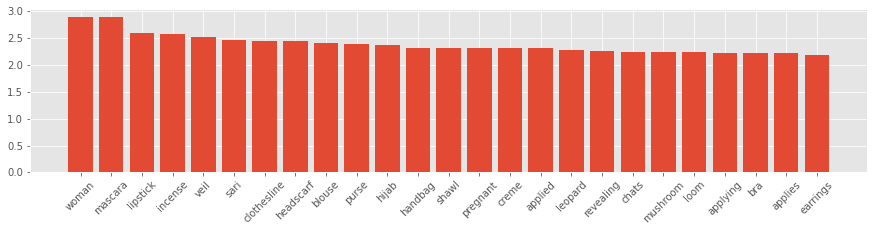

In [34]:
get_n_highest('woman', pmi_premise, n=25, plot=True)

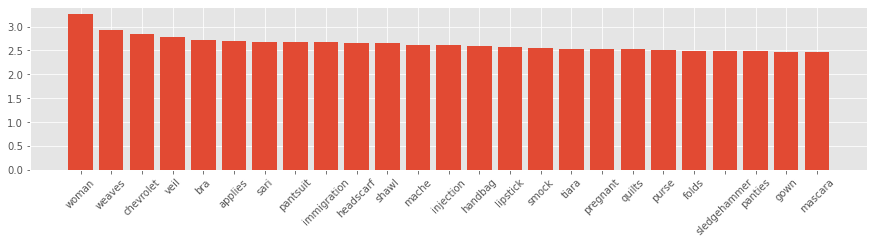

In [35]:
get_n_highest('woman', pmi_hyp, n=25, plot=True)

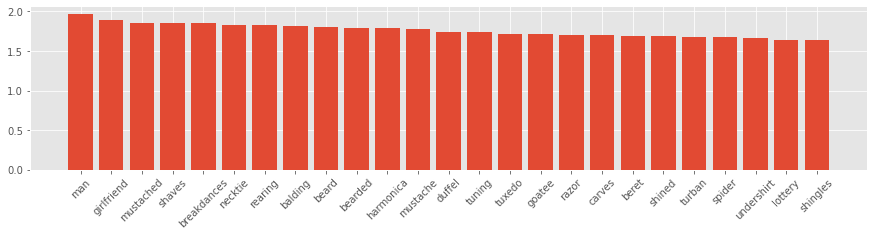

In [36]:
get_n_highest('man', pmi_premise, n=25, plot=True)

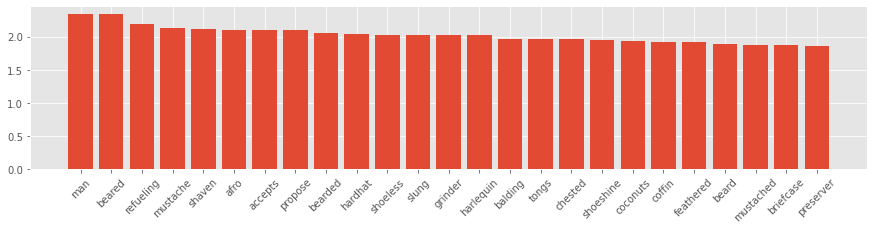

In [37]:
get_n_highest('man', pmi_hyp, n=25, plot=True)

In [38]:
pd.set_option('display.max_rows', 1000)

In [39]:
p_availabilities = {}

for identity in identities:
    p_availabilities[identity] = len(get_n_highest(identity, pmi_premise, n=10000, plot=False))

In [40]:
h_availabilities = {}

for identity in identities:
    h_availabilities[identity] = len(get_n_highest(identity, pmi_hyp, n=10000, plot=False))

In [41]:
def compare(w1, w2, source):
    df = pd.DataFrame()
    
    intersection = \
        [b for ((a,b), c) in get_n_highest(w1, source, n=10000, plot=False) \
         if b in [y for ((x,y),z) in get_n_highest(w2, source, n=10000, plot=False)]]

    words = []
    pmis_w1 = []
    pmis_w2 = []

    for word in intersection:
        pmi_w1 = source[(w1, word)]
        pmi_w2 = source[(w2, word)]

        words.append(word)
        pmis_w1.append(pmi_w1)
        pmis_w2.append(pmi_w2)

    df["words"] = words
    df["pmi_" + w1] = pmis_w1
    df["pmi_" + w2] = pmis_w2
    df["diff"] = df["pmi_" + w1] - df["pmi_" + w2]
    
    return df

In [42]:
def find_sentence(w1, w2, source="premise"):
    if source=="premise":
        sent = "sentence1"
    else:
        sent = "sentence2"
        
    res = set()
    count = 0
    for sentence in train[sent].values:
        if isinstance(sentence, float):
            continue
        if w1 in sentence and w2 in sentence:
            count += 1                
            res.add(sentence)
            
    return res

In [43]:
list(find_sentence("asian", "girl", "hypothesis"))[:10]

['Two asian girls have no hair.',
 'A small asian girl enjoying playing out in the countryside.',
 'A preteen Caucasian girl is floating on a round bowl using a wooden object to paddle.',
 'A caucasian man gives an Asian girl a balloon',
 'The girl is asian.',
 'Lush, well-watered foliage frames the two asian girls as they pose for a picture',
 'A small asian girl with blonde hair is sitting on a merry-go-round.',
 'An asian little girl walking outside.',
 'The two asian girls are Japanese.',
 'A small asian girl is sitting on a merry-go-round.']

### Comparison between female-male

In [44]:
female_male_prem = compare('female', 'male', source=pmi_premise)

In [45]:
female_male_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_female,pmi_male,diff
29,skater,3.897352,0.346151,3.551201
249,marathon,2.022883,-1.068886,3.091769
0,female,6.880864,4.045723,2.835141
90,volleyball,3.030929,0.306892,2.724038
407,bowling,1.449018,-1.227714,2.676732
35,lacrosse,3.632936,0.956205,2.676732
263,roller,1.973973,-0.702758,2.676732
499,counter,1.180424,-1.496308,2.676732
1134,runs,-0.659587,-3.336319,2.676732
617,outdoors,0.852456,-1.698745,2.551201


In [46]:
female_male_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_female,pmi_male,diff
1309,trick,-2.429749,1.937913,-4.367662
1264,surfer,-1.472283,2.605873,-4.078156
1321,covered,-3.054301,0.438892,-3.493193
1289,plaid,-1.977117,1.101039,-3.078156
1303,takes,-2.338305,0.739851,-3.078156
1071,skinned,-0.422917,2.485314,-2.908231
24,male,4.045723,6.789095,-2.743372
1256,mask,-1.422917,1.070276,-2.493193
1126,skate,-0.618982,1.874211,-2.493193
1123,catches,-0.602952,1.890241,-2.493193


In [47]:
female_male_hyp = compare('female', 'male', source=pmi_hyp)

In [48]:
female_male_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_female,pmi_male,diff
0,female,7.681122,4.112066,3.569056
376,jump,1.049525,-2.276222,3.325747
585,pink,0.433194,-2.777076,3.210270
346,swim,1.190727,-1.894012,3.084739
258,skier,1.672133,-1.275102,2.947236
688,painting,0.194622,-2.600610,2.795232
15,speaker,4.178622,1.383389,2.795232
465,fence,0.762259,-1.863049,2.625307
157,performers,2.284517,-0.340790,2.625307
374,smiling,1.076260,-1.455938,2.532198


In [49]:
female_male_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_female,pmi_male,diff
17,male,4.112066,8.055814,-3.943749
1142,skateboard,-1.835563,1.626592,-3.462155
1176,lunch,-3.030545,0.344148,-3.374693
562,youth,0.481450,3.856142,-3.374693
1151,waits,-2.062029,1.120018,-3.182047
1157,vehicle,-2.216723,0.965324,-3.182047
754,drummer,0.059070,3.241118,-3.182047
880,performer,-0.352301,2.722831,-3.075132
1175,fire,-2.992187,-0.032532,-2.959655
641,african,0.306083,3.183275,-2.877193


### Comparison between woman-man

In [50]:
woman_man = compare('woman', 'man', source=pmi_premise)

In [51]:
woman_man.sort_values("pmi_woman", ascending=False).head(5)

,words,pmi_woman,pmi_man,diff
0,woman,2.890697,-0.279789,3.170486
1,lipstick,2.591136,-2.035247,4.626383
2,veil,2.528127,-2.205172,4.733298
3,sari,2.454598,-1.558809,4.013406
4,clothesline,2.443238,-2.942137,5.385375


In [52]:
woman_man.sort_values("pmi_man", ascending=False).head(5)

,words,pmi_woman,pmi_man,diff
2457,man,-0.279789,1.964753,-2.244542
3225,breakdances,-0.809743,1.849276,-2.659019
2910,necktie,-0.568735,1.827250,-2.395985
3239,balding,-0.825510,1.816231,-2.641741
3707,beard,-1.337285,1.809399,-3.146684


In [53]:
woman_man[woman_man["words"] == "topless"]

,words,pmi_woman,pmi_man,diff
295,topless,1.242999,0.217519,1.025479


In [54]:
woman_man[woman_man["words"] == "dances"]

,words,pmi_woman,pmi_man,diff
386,dances,1.147855,0.335122,0.812733


In [55]:
woman_man[woman_man["words"] == "football"]

,words,pmi_woman,pmi_man,diff
4239,football,-3.073644,-1.677659,-1.395985


In [56]:
woman_man.sort_values("diff", ascending=False).head(50)

,words,pmi_woman,pmi_man,diff
9,handbag,2.323656,-3.357175,5.680831
4,clothesline,2.443238,-2.942137,5.385375
531,derby,0.997612,-4.320649,5.318261
2,veil,2.528127,-2.205172,4.733298
1,lipstick,2.591136,-2.035247,4.626383
70,rabbits,1.890697,-2.620209,4.510906
60,scantily,1.957811,-2.427564,4.385375
38,attractive,2.060622,-2.035247,4.095868
3,sari,2.454598,-1.558809,4.013406
20,bra,2.212625,-1.772212,3.984837


In [57]:
# soccer, baseball, basketball, football

In [58]:
woman_man.sort_values("diff", ascending=True).head(50)

,words,pmi_woman,pmi_man,diff
4282,scaffolding,-4.228244,0.573733,-4.801977
4280,snowboard,-4.186119,0.379791,-4.565910
4258,donkey,-3.394705,1.138783,-4.533488
4285,ramp,-4.325241,0.021834,-4.347075
4271,trick,-3.834954,0.368386,-4.203340
4254,skateboarding,-3.338122,0.780329,-4.118451
4262,barrel,-3.466855,0.607201,-4.074057
4191,banjo,-2.601156,1.427097,-4.028253
4124,razor,-2.279228,1.701719,-3.980947
4266,tricks,-3.663892,0.292808,-3.956700


In [59]:
woman_man_hyp = compare('woman', 'man', source=pmi_hyp)

In [60]:
woman_man_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_woman,pmi_man,diff
6165,barbecue,-4.064932,0.745309,-4.810241
6010,shaven,-2.497891,2.107991,-4.605882
6033,wife,-2.624208,1.741337,-4.365545
6127,trunks,-3.401215,0.635301,-4.036517
6008,camouflage,-2.497891,1.491319,-3.989211
6132,cave,-3.470924,0.518286,-3.989211
5905,girlfriend,-2.169269,1.771033,-3.940301
5846,tuxedo,-1.990931,1.828354,-3.819286
6103,wheeler,-3.135321,0.590855,-3.726176
5850,razor,-1.990931,1.614951,-3.605882


In [61]:
woman_man_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_woman,pmi_man,diff
37,boyfriend,2.220654,-2.989807,5.210462
1,weaves,2.935068,-1.982612,4.917680
44,husband,2.168076,-2.475048,4.643124
2,chevrolet,2.841959,-1.660684,4.502642
11,tiara,2.520030,-1.982612,4.502642
2141,derby,0.300585,-4.009412,4.309997
6,shawl,2.646943,-1.518665,4.165607
62,incense,2.034604,-2.053001,4.087605
659,lanterns,1.069369,-3.018236,4.087605
0,woman,3.256996,-0.744130,4.001126


### Comparison between women-men

In [62]:
women_men_prem = compare('women', 'men', source=pmi_premise)

In [63]:
women_men_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_women,pmi_men,diff
2,bikinis,4.352259,-1.307971,5.660231
1312,scarf,-0.013646,-4.673877,4.660231
20,knitting,2.965236,-1.588079,4.553316
0,women,4.937222,0.527263,4.409959
215,softball,1.615294,-2.697014,4.312307
1533,baby,-0.305139,-4.515567,4.210428
195,library,1.735588,-2.439216,4.174804
6,dresses,3.716346,-0.317102,4.033448
7,kimonos,3.714829,-0.307971,4.022801
3,headdresses,4.299792,0.276991,4.022801


In [64]:
women_men_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_women,pmi_men,diff
2333,vests,-2.429100,2.826548,-5.255649
2389,roof,-3.459383,1.469101,-4.928484
2398,shirtless,-4.085146,0.762418,-4.847564
2107,guitars,-1.348180,3.102725,-4.450905
2400,snowy,-4.364274,-0.409795,-3.954479
2326,camouflage,-2.384706,1.517305,-3.902012
2303,rugby,-2.232703,1.614861,-3.847564
1987,chess,-1.016974,2.830589,-3.847564
2362,construction,-2.725743,1.045872,-3.771615
2316,railroad,-2.329565,1.402522,-3.732087


In [65]:
women_men_hyp = compare('women', 'men', source=pmi_hyp)

In [66]:
women_men_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_women,pmi_men,diff
1884,men,-0.160546,4.298382,-4.458928
3202,repairing,-2.208768,1.722697,-3.931465
3278,pipe,-2.700828,1.053760,-3.754587
3344,brothers,-3.854484,-0.099897,-3.754587
3322,tractor,-3.268034,0.355309,-3.623343
1828,tuxedos,-0.102568,3.520774,-3.623343
3264,arena,-2.562000,1.061343,-3.623343
3238,jet,-2.400249,1.223094,-3.623343
3298,sticks,-2.949452,0.603502,-3.552954
3330,sunset,-3.452280,-0.051329,-3.400950


In [67]:
women_men_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_women,pmi_men,diff
0,women,5.067357,-0.160546,5.227902
52,salon,2.642859,-2.374043,5.016902
1067,purse,0.557299,-4.019031,4.576329
64,beauty,2.558343,-1.911071,4.469414
2397,sweater,-0.648138,-4.876544,4.228406
3,gossip,4.137746,-0.023546,4.161292
2584,husband,-0.884511,-4.975414,4.090903
181,belly,1.897432,-2.041468,3.938900
45,spa,2.713720,-1.225180,3.938900
542,weaving,1.234466,-2.534508,3.768975


### Comparison between girl-boy

In [68]:
girl_boy_prem = compare('girl', 'boy', source=pmi_premise)

In [69]:
girl_boy_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_girl,pmi_boy,diff
114,bikini,1.950046,-3.928029,5.878075
3,pigtails,3.643191,-1.819847,5.463038
45,polka,2.421164,-2.759474,5.180638
38,softball,2.470640,-2.670469,5.141109
313,blouse,1.348249,-3.146497,4.494746
54,dot,2.332053,-2.098563,4.430616
371,brunette,1.193332,-2.777853,3.971184
140,candles,1.834147,-2.137037,3.971184
643,purse,0.739683,-3.038857,3.778539
865,guy,0.453258,-3.272814,3.726072


In [70]:
girl_boy_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_girl,pmi_boy,diff
2431,trunks,-1.738104,2.630561,-4.368666
2679,ramp,-3.718825,0.595393,-4.314218
2667,stunt,-3.239853,0.876425,-4.116278
2461,gun,-1.832809,1.932973,-3.765781
2007,spiderman,-0.872121,2.857134,-3.729255
2668,boats,-3.257775,0.471480,-3.729255
2658,pipe,-3.087850,0.641405,-3.729255
881,boy,0.434244,4.110890,-3.676646
2143,elmo,-1.047208,2.566570,-3.613778
2605,pitch,-2.517838,0.970409,-3.488247


In [71]:
girl_boy_hyp = compare('girl', 'boy', source=pmi_hyp)

In [72]:
girl_boy_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_girl,pmi_boy,diff
3677,trunks,-3.254483,2.699150,-5.953632
1890,boy,-0.029914,4.450470,-4.480385
3728,son,-5.124725,-1.323096,-3.801629
2714,dribbles,-0.766196,2.739977,-3.506173
3653,structure,-2.904610,0.534449,-3.439059
3481,action,-2.072005,1.296665,-3.368670
3358,superman,-1.725554,1.643116,-3.368670
2750,pirate,-0.805725,2.488945,-3.294669
3663,jet,-3.063877,0.152790,-3.216667
2278,grins,-0.351159,2.865508,-3.216667


In [73]:
girl_boy_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_girl,pmi_boy,diff
137,beam,1.998745,-2.709401,4.708146
65,bikini,2.328131,-2.343945,4.672076
105,softball,2.136942,-2.401279,4.538221
0,girl,4.403729,-0.029914,4.433643
16,leotard,2.951216,-1.249969,4.201186
200,roses,1.818766,-2.041383,3.860149
2584,guy,-0.627750,-4.305901,3.678151
490,heels,1.209351,-2.444347,3.653698
1,dolls,3.374777,-0.202972,3.577749
789,camel,0.869750,-2.668471,3.538221


### Comparison between girls-boys

In [74]:
girls_boys_prem = compare('girls', 'boys', source=pmi_premise)

In [75]:
girls_boys_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_girls,pmi_boys,diff
0,girls,5.911646,1.200306,4.711340
2,dresses,4.188269,0.354167,3.834102
374,event,0.591974,-2.979095,3.571068
58,roller,2.326683,-1.151276,3.477959
19,dance,2.976441,-0.482153,3.458593
115,bubbles,1.842484,-1.535939,3.378423
877,sunglasses,-0.850510,-3.881010,3.030500
300,book,0.844531,-2.118854,2.963385
140,dancing,1.677180,-1.244385,2.921565
673,cellphone,-0.262281,-3.155277,2.892996


In [76]:
girls_boys_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_girls,pmi_boys,diff
220,boys,1.200306,6.340578,-5.140272
1093,kicking,-2.248226,1.765669,-4.013894
1008,muddy,-1.531298,2.357066,-3.888364
1143,cart,-3.607991,0.142869,-3.750860
1144,skateboard,-3.760780,-0.161923,-3.598857
1112,fruit,-2.463394,1.135463,-3.598857
1077,kick,-2.001244,1.427688,-3.428932
1049,digging,-1.767834,1.468452,-3.236287
1015,skate,-1.588200,1.648087,-3.236287
847,sticks,-0.739406,2.274488,-3.013894


In [77]:
girls_boys_hyp = compare('girls', 'boys', source=pmi_hyp)

In [78]:
girls_boys_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_girls,pmi_boys,diff
0,girls,6.086324,0.867986,5.218338
4,dresses,3.735102,-0.111448,3.846550
540,umbrella,0.598038,-3.133035,3.731073
187,tea,1.710263,-1.938348,3.648610
69,derby,2.438036,-0.823551,3.261587
998,busy,-0.328713,-3.474823,3.146110
624,club,0.419051,-2.601528,3.020579
245,eachother,1.489389,-1.393687,2.883076
106,nails,2.141466,-0.741610,2.883076
9,gossiping,3.525609,0.642534,2.883076


In [79]:
girls_boys_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_girls,pmi_boys,diff
434,boys,0.867986,6.525177,-5.657191
1603,skateboarding,-3.115800,0.908015,-4.023815
1573,digging,-2.717807,1.306008,-4.023815
276,marbles,1.331437,5.092217,-3.760781
1510,fruit,-1.997598,1.379854,-3.377452
1486,puddle,-1.862043,1.384164,-3.246207
1201,learn,-0.746566,2.499642,-3.246207
1427,skills,-1.506133,1.740075,-3.246207
1596,desk,-2.960800,0.285408,-3.246207
910,splash,-0.142494,3.103713,-3.246207


### Comparison between white/caucasian-black/african

In [80]:
white_black_prem = compare('white', 'black', source=pmi_premise)
white_black_hyp = compare('white', 'black', source=pmi_hyp)

cauc_af_prem = compare('caucasian', 'african', source=pmi_premise)
cauc_af_hyp = compare('caucasian', 'african', source=pmi_hyp)

In [81]:
white_black_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_black,diff
2433,overlooking,-0.393341,-4.369753,3.976412
25,rafting,2.266845,-1.429459,3.696304
2,footballer,3.183516,-0.027361,3.210877
1787,driver,0.002187,-3.208691,3.210877
659,pitcher,0.827641,-2.231233,3.058874
77,substance,1.931978,-1.126896,3.058874
177,clouds,1.586481,-1.389931,2.976412
2088,college,-0.151236,-3.040185,2.888949
469,crane,1.036675,-1.759165,2.795840
1031,scaffolding,0.456893,-2.338947,2.795840


In [82]:
white_black_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_black,diff
3508,sled,-3.854619,-0.158605,-3.696013
3428,shining,-1.885646,1.225405,-3.111051
3405,graduation,-1.757321,1.353729,-3.111051
3497,balance,-2.900912,0.210138,-3.111051
3314,mic,-1.460340,1.458066,-2.918406
3486,push,-2.597843,0.320562,-2.918406
3459,chalkboard,-2.138412,0.779994,-2.918406
2816,blazer,-0.723374,2.088116,-2.811491
3493,hall,-2.790488,-0.094475,-2.696013
3494,raises,-2.822910,-0.126896,-2.696013


In [83]:
white_black_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_black,diff
481,tent,1.590928,-3.203487,4.794416
570,great,1.362376,-2.547517,3.909893
1481,volleyball,-0.031999,-3.700884,3.668885
963,six,0.716112,-2.952773,3.668885
1344,married,0.158672,-3.220707,3.379378
100,hood,2.871390,-0.507988,3.379378
0,white,6.193318,2.891224,3.302094
650,pouring,1.198965,-2.010489,3.209453
480,dirty,1.604603,-1.604850,3.209453
786,plate,0.988747,-2.220707,3.209453


In [84]:
white_black_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_black,diff
1925,funeral,-0.795367,2.802535,-3.597902
593,belts,1.335337,4.880771,-3.545434
2352,piano,-2.692378,0.798608,-3.490986
2355,museum,-2.710564,0.539414,-3.249978
2363,musician,-3.121832,0.128147,-3.249978
2365,surfing,-3.157621,-0.045146,-3.112475
97,black,2.891224,5.983865,-3.092640
1451,mustache,0.023393,2.983865,-2.960472
2347,closed,-2.482639,0.477833,-2.960472
1081,wetsuit,0.520893,3.398902,-2.878009


#### Caucasian/African

In [85]:
cauc_af_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_african,diff
0,caucasian,10.343683,4.119682,6.224002
4,link,5.758721,2.392700,3.366021
19,blouse,4.086296,0.720275,3.366021
16,button,4.163774,0.797754,3.366021
89,metal,2.067559,-1.298462,3.366021
79,sunny,2.288401,-1.077620,3.366021
36,brunette,3.454940,0.088920,3.366021
64,aged,2.714327,-0.651694,3.366021
44,music,3.100510,-0.265511,3.366021
120,trying,1.638051,-1.727970,3.366021


In [86]:
cauc_af_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_african,diff
0,caucasian,11.977980,5.017978,6.960002
22,wears,3.537803,-0.112343,3.650147
5,straw,6.132490,3.067306,3.065184
16,teacher,3.997841,0.932657,3.065184
85,player,1.001058,-2.064126,3.065184
35,holds,2.913238,-0.151947,3.065184
29,female,3.371267,0.306083,3.065184
19,blond,3.720592,1.070446,2.650147
81,old,1.241860,-1.408286,2.650147
45,four,2.630580,0.243468,2.387112


### Comparison between white/caucasian-asian

In [87]:
white_asian_prem = compare('white', 'asian', source=pmi_premise)
white_asian_hyp = compare('white', 'asian', source=pmi_hyp)

cauc_asian_prem = compare('caucasian', 'asian', source=pmi_premise)
cauc_asian_hyp = compare('caucasian', 'asian', source=pmi_hyp)

In [88]:
white_asian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_asian,diff
80,dog,1.524448,-3.844187,5.368635
441,jumps,0.541652,-4.203568,4.745220
337,players,0.734038,-3.918735,4.652774
552,dogs,0.398777,-3.993083,4.391859
193,mouth,1.053803,-3.190988,4.244791
41,jersey,1.794474,-2.355799,4.150273
166,catch,1.104814,-2.999655,4.104470
164,helmet,1.109587,-2.947577,4.057164
0,white,3.668943,-0.219635,3.888579
651,snow,0.290432,-3.535407,3.825838


In [89]:
white_asian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_asian,diff
1187,asian,-0.219635,6.103632,-6.323268
1527,descent,-0.628737,5.308452,-5.937189
1934,characters,-1.652985,3.781704,-5.434689
1885,dragon,-1.418520,3.823524,-5.242044
2014,passengers,-2.854619,2.165033,-5.019652
968,east,-0.031496,4.725121,-4.756617
1919,community,-1.578984,2.855705,-4.434689
1928,bananas,-1.616459,2.818230,-4.434689
2001,buy,-2.540510,1.894179,-4.434689
1944,supermarket,-1.723374,2.711315,-4.434689


In [90]:
white_asian_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_asian,diff
0,white,6.193318,0.229459,5.963859
118,dog,1.845743,-3.110000,4.955743
39,uniform,2.635867,-2.047256,4.683123
27,brown,2.826371,-1.435288,4.261659
67,helmet,2.249501,-1.959691,4.209192
30,uniforms,2.788928,-1.337802,4.126730
213,cat,1.234748,-2.628947,3.863695
11,shirts,3.276679,-0.475305,3.751985
203,team,1.291432,-2.429658,3.721091
589,dogs,0.174481,-3.436328,3.610809


In [91]:
white_asian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_asian,diff
566,asian,0.229459,7.739014,-7.509555
1310,chess,-2.220310,2.910348,-5.130658
1346,musicians,-3.266114,1.086937,-4.353051
1336,classroom,-2.781097,1.571954,-4.353051
1330,sisters,-2.544774,1.585884,-4.130658
1277,serving,-1.941108,1.926515,-3.867624
652,japan,0.064035,3.931659,-3.867624
1139,lined,-1.249625,2.617998,-3.867624
1091,tourists,-1.067210,2.800414,-3.867624
1004,baskets,-0.795367,3.072257,-3.867624


In [92]:
cauc_asian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_caucasian,pmi_asian,diff
0,caucasian,10.343683,1.245651,9.098032
17,heavily,5.728974,0.488923,5.240051
118,goggles,2.968644,-2.271407,5.240051
146,midair,2.539552,-2.700499,5.240051
64,skinned,4.039903,-1.200148,5.240051
59,blouse,4.086296,-1.153755,5.240051
55,african,4.119682,-0.798441,4.918123
57,live,4.095756,-0.144295,4.240051
25,perhaps,5.256221,1.016170,4.240051
21,scout,5.588796,1.348745,4.240051


In [93]:
cauc_asian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_asian,diff
53,asian,3.429158,7.739014,-4.309855
199,street,-1.239977,0.565450,-1.805427
187,women,-0.242499,1.317276,-1.559775
180,food,0.025239,1.458698,-1.433459
196,eating,-0.575889,0.739733,-1.315622
189,taking,-0.298726,0.888572,-1.187298
197,looking,-0.935844,0.182741,-1.118585
200,person,-2.077217,-1.030782,-1.046436
185,sits,-0.076963,0.684070,-0.761033
186,working,-0.241793,0.473436,-0.715230


### Comparison between white/caucasian-indian

In [94]:
white_indian_prem = compare('white', 'indian', source=pmi_premise)
white_indian_hyp = compare('white', 'indian', source=pmi_hyp)

cauc_indian_prem = compare('caucasian', 'indian', source=pmi_premise)
cauc_indian_hyp = compare('caucasian', 'indian', source=pmi_hyp)

In [95]:
white_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_indian,diff
298,indian,-0.002252,9.006908,-9.009159
489,saris,-0.578984,6.758980,-7.337964
242,sari,0.145381,6.805274,-6.659892
623,shining,-1.885646,4.452319,-6.337964
591,riverbank,-1.237947,5.100017,-6.337964
173,ritual,0.347015,6.684980,-6.337964
609,nurse,-1.578984,4.758980,-6.337964
504,descent,-0.628737,5.709227,-6.337964
445,drawings,-0.418520,5.919445,-6.337964
595,traditional,-1.285253,4.830319,-6.115572


In [96]:
white_indian_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_indian,diff
54,ball,0.942660,-2.820038,3.762698
0,white,3.668943,-0.002252,3.671195
18,brown,1.496454,-2.037486,3.533941
12,shorts,1.576699,-1.876499,3.453199
27,top,1.256241,-2.137113,3.393355
13,black,1.559021,-1.607408,3.166429
29,jeans,1.236962,-1.782626,3.019588
302,person,-0.018688,-3.011640,2.992953
88,hair,0.671764,-2.312200,2.983964
128,field,0.476298,-2.452524,2.928822


In [97]:
white_indian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_white,pmi_indian,diff
331,indian,-0.701500,10.393018,-11.094518
249,style,-0.146532,7.375096,-7.521628
251,native,-0.164234,6.035466,-6.199700
193,traditional,0.185823,6.259992,-6.074169
274,crossed,-0.345841,5.438822,-5.784662
396,conversing,-1.073469,4.126231,-5.199700
54,guest,1.438431,6.638130,-5.199700
121,loom,0.733886,5.933586,-5.199700
433,vendor,-1.416476,3.783223,-5.199700
476,officers,-2.380329,2.819371,-5.199700


In [98]:
white_indian_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_white,pmi_indian,diff
0,white,6.193318,-0.701500,6.894818
4,black,2.891224,-2.495916,5.387140
2,shirt,3.311775,-0.770841,4.082616
82,ball,1.011292,-2.065132,3.076425
16,blue,2.252212,-0.606982,2.859194
19,jacket,2.172482,-0.485799,2.658281
47,yellow,1.579434,-0.962333,2.541767
89,player,0.944316,-1.583904,2.528221
8,shorts,2.699909,0.213109,2.486801
52,horse,1.455052,-0.945161,2.400213


In [99]:
cauc_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_indian,diff
155,clothing,0.476405,3.046519,-2.570115
160,dancing,0.436793,2.684980,-2.248187
185,women,0.079241,2.027867,-1.948626
210,talking,-0.588531,1.244618,-1.833149
192,ground,-0.060394,1.772755,-1.833149
220,girls,-0.946335,0.886814,-1.833149
230,next,-1.440951,0.392198,-1.833149
223,stands,-1.097186,0.373393,-1.470579
212,older,-0.707525,0.763054,-1.470579
126,clothes,0.882204,2.352783,-1.470579


In [100]:
cauc_indian_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_caucasian,pmi_indian,diff
14,indian,3.498200,10.393018,-6.894818
105,women,-0.242499,1.835504,-2.078003
98,food,0.025239,1.899708,-1.874469
78,dancing,0.560655,1.975693,-1.415037
68,using,0.671349,1.671349,-1.000000
104,working,-0.241793,0.758207,-1.000000
108,crowd,-0.345919,0.654081,-1.000000
28,vendor,2.783223,3.783223,-1.000000
67,music,0.676484,1.676484,-1.000000
90,woman,0.269069,1.025143,-0.756074


### Comparison between asian-indian

In [101]:
asian_indian_prem = compare('asian', 'indian', source=pmi_premise)
asian_indian_hyp = compare('asian', 'indian', source=pmi_hyp)

In [102]:
asian_indian_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_asian,pmi_indian,diff
508,indian,-1.091124,9.006908,-10.098032
58,sari,1.580070,6.805274,-5.225203
514,mat,-1.172492,3.315746,-4.488238
321,fabric,0.070209,4.295413,-4.225203
274,native,0.245651,4.470855,-4.225203
426,crossed,-0.404162,3.499113,-3.903275
333,cooks,-0.004892,3.898383,-3.903275
63,thinking,1.518670,5.421945,-3.903275
64,cultural,1.518670,5.421945,-3.903275
490,performers,-0.862152,3.041123,-3.903275


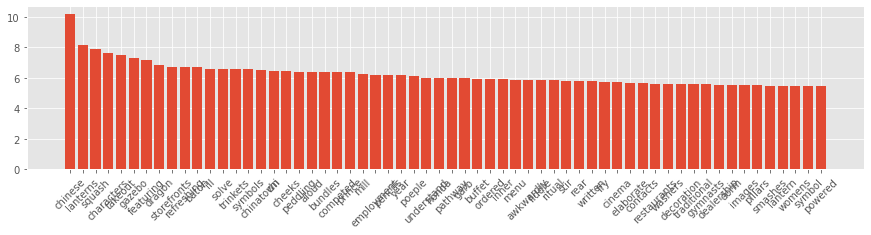

In [103]:
get_n_highest('chinese', pmi_hyp, n=60, plot=True)

### Comparison between young-old/elderly

In [104]:
young_old_prem = compare('young', 'old', source=pmi_premise)
young_old_hyp = compare('young', 'old', source=pmi_hyp)

young_eld_prem = compare('young', 'elderly', source=pmi_premise)
young_eld_hyp = compare('young', 'elderly', source=pmi_hyp)

In [105]:
young_old_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_old,diff
1716,cane,-3.810066,3.897873,-7.707939
1183,old,-0.373822,6.640377,-7.014199
1004,fashioned,-0.174478,6.640377,-6.814854
1588,ruins,-1.225104,3.782396,-5.007499
1613,antique,-1.367123,3.640377,-5.007499
1648,fat,-1.615050,3.392449,-5.007499
704,fashion,0.130377,4.874842,-4.744465
1701,sides,-2.670904,1.921558,-4.592462
1396,cannon,-0.759440,3.833022,-4.592462
1465,besides,-0.890685,3.701777,-4.592462


In [106]:
young_old_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_old,diff
0,young,3.632877,-0.373822,4.006699
243,swimming,0.726823,-3.111168,3.837991
404,soccer,0.443748,-3.185377,3.629125
810,football,0.026088,-3.323964,3.350053
999,runs,-0.170608,-3.485037,3.314429
183,fountain,0.867342,-2.353977,3.221319
89,skateboard,1.140361,-2.032049,3.172410
497,body,0.329096,-2.833329,3.162426
27,girl,1.581394,-1.572322,3.153716
43,girls,1.400850,-1.649642,3.050492


In [107]:
young_old_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_old,diff
1712,fashioned,-0.447412,6.487585,-6.934997
1393,old,-0.125991,6.551716,-6.677707
1248,years,0.017256,5.721641,-5.704384
2062,twenty,-0.946218,3.699273,-4.645491
2323,banjo,-1.781831,2.693735,-4.475566
2234,days,-1.366793,3.108772,-4.475566
1521,knits,-0.245778,4.229787,-4.475566
1996,times,-0.830741,3.452180,-4.282920
2307,younger,-1.669804,2.468726,-4.138531
2417,least,-3.354302,0.706226,-4.060528


In [108]:
young_old_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_old,diff
0,young,5.076150,-0.125991,5.202141
300,blonde,1.070406,-3.008617,4.079023
309,slide,1.039379,-3.008617,4.047996
125,karate,1.513214,-2.470652,3.983866
454,practicing,0.792646,-3.017191,3.809837
202,classroom,1.271660,-2.422699,3.694359
40,adults,2.110854,-1.563328,3.674182
243,girls,1.172319,-2.427403,3.599723
231,arts,1.222699,-2.346130,3.568829
181,swings,1.330505,-2.051911,3.382415


In [109]:
young_eld_prem.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_elderly,diff
6,boys,1.832486,-3.563304,5.395790
0,young,3.632877,-0.985603,4.618480
11,girl,1.581394,-2.499879,4.081273
139,pool,0.872526,-3.142048,4.014575
7,boy,1.814733,-1.985636,3.800369
288,children,0.491521,-2.738391,3.229912
337,sand,0.396218,-2.784366,3.180584
179,swimming,0.726823,-2.453761,3.180584
25,girls,1.400850,-1.670308,3.071158
110,blond,0.959551,-2.085202,3.044753


In [110]:
young_eld_prem.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_elderly,diff
1309,cane,-3.810066,4.899233,-8.709300
1144,elderly,-0.985603,7.297783,-8.283385
601,canes,0.047915,6.034748,-5.986834
1300,patient,-2.516870,3.148036,-5.664906
1298,cage,-2.411517,2.838351,-5.249868
1119,register,-0.890685,4.359183,-5.249868
1283,bush,-2.010979,3.238889,-5.249868
1094,paintbrush,-0.826555,4.423314,-5.249868
1293,rally,-2.321319,2.928549,-5.249868
1302,couples,-2.537048,2.712820,-5.249868


In [111]:
young_eld_hyp.sort_values("diff", ascending=False).head(50)

,words,pmi_young,pmi_elderly,diff
0,young,5.076150,-0.970543,6.046693
88,girls,1.172319,-4.208296,5.380616
22,girl,1.829272,-3.083537,4.912809
18,boy,1.972930,-2.522222,4.495152
211,pool,0.740527,-3.192074,3.932601
95,school,1.161211,-2.496633,3.657844
340,jumping,0.446365,-3.139071,3.585436
621,ball,0.001704,-2.879973,2.881677
395,air,0.343590,-2.511935,2.855525
191,child,0.780096,-2.055499,2.835595


In [112]:
young_eld_hyp.sort_values("diff", ascending=True).head(50)

,words,pmi_young,pmi_elderly,diff
1071,elderly,-0.970543,8.578177,-9.548721
1096,mustache,-1.093775,4.408252,-5.502027
906,gentleman,-0.487182,4.792452,-5.279635
930,raincoat,-0.538560,4.548430,-5.086990
932,sleeved,-0.538560,4.548430,-5.086990
1201,medical,-1.830741,3.256249,-5.086990
1168,walmart,-1.478439,3.608551,-5.086990
954,professionals,-0.596275,4.490715,-5.086990
894,fashioned,-0.447412,4.639578,-5.086990
727,cane,-0.148816,4.938173,-5.086990


# POPULAR STEREOTYPES ANALYSIS

### Sports

In [113]:
get_pmi("woman", "player"), get_pmi("man", "player")

(-2.8702845032144824, -3.144151186229639)

In [114]:
get_pmi("woman", "football"), get_pmi("man", "football")

(-3.073644110930758, -1.6776593956382457)

In [115]:
get_pmi("woman", "basketball"), get_pmi("man", "basketball")

(-2.5850366741047375, -1.0780206464234812)

In [116]:
get_pmi("woman", "sports"), get_pmi("man", "sports")

(-0.6988823719298658, -0.0033373747784456688)

In [117]:
get_pmi("girl", "sports"), get_pmi("boy", "sports")

(-0.5075042608212358, 0.21318900991680423)

In [118]:
get_pmi("girls", "baseball"), get_pmi("boys", "baseball")

(-1.0506720131635132, -0.036777571505132375)

In [119]:
get_pmi("girl", "baseball"), get_pmi("boy", "baseball")

(-0.7759061271572818, 0.9455857569644998)

### Are women really #domesticated ?

In [120]:
get_pmi("woman", "kitchen"), get_pmi("man", "kitchen")

(0.6160098280829995, 0.14332326999748335)

In [121]:
get_pmi("woman", "groceries"), get_pmi("man", "groceries")

(1.3918908998902189, -0.598182817124347)

In [122]:
get_pmi("woman", "laundry"), get_pmi("man", "laundry")

(1.2169249891826481, -0.05694169383250857)

In [123]:
get_pmi("woman", "ironing")

2.1022008620553723

In [124]:
get_pmi("woman", "dishwasher")

2.05419548914454

In [125]:
get_pmi("woman", "apron"), get_pmi("man", "apron")

(1.4386285266378496, 0.9562917985186143)

In [126]:
get_pmi("woman", "sewing"), get_pmi("man", "sewing")

(1.771755684138153, 0.3693742606003158)

In [127]:
get_pmi("woman", "knitting")

1.8032339156113208

### School

In [128]:
get_pmi("woman", "children"), get_pmi("man", "children")

(-0.8554580087592063, -1.709476461551433)

In [129]:
get_pmi("woman", "school"), get_pmi("man", "school")

(-1.5016206659170999, -2.2755609520669)

In [130]:
get_pmi("girls", "school"), get_pmi("boys", "school")

(1.9932594073324466, 2.100263253382309)

In [131]:
get_pmi("girl", "school"), get_pmi("boy", "school")

(0.5642265631076713, 0.35600293190719384)

In [132]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'school' == j], key=lambda x: x[1], reverse=True)

[(('muslim', 'school'), 3.2818700598722566),
 (('french', 'school'), 3.1158601084333273),
 (('teenage', 'school'), 3.109601117961645),
 (('caucasian', 'school'), 2.781441069362768),
 (('teenagers', 'school'), 2.363297659216103),
 (('boys', 'school'), 2.100263253382309),
 (('girls', 'school'), 1.9932594073324466),
 (('japanese', 'school'), 1.938982346349248),
 (('mother', 'school'), 1.7608601919403162),
 (('african', 'school'), 1.7373484851795975),
 (('asian', 'school'), 1.1263524822509696),
 (('american', 'school'), 0.902456470324134),
 (('son', 'school'), 0.8778708320458608),
 (('female', 'school'), 0.6405496104960655),
 (('girl', 'school'), 0.5642265631076713),
 (('indian', 'school'), 0.44466521006809234),
 (('young', 'school'), 0.39256273055077884),
 (('boy', 'school'), 0.35600293190719384),
 (('male', 'school'), 0.22685221768513059),
 (('old', 'school'), -0.3369033799533328),
 (('men', 'school'), -0.8929338607985076),
 (('white', 'school'), -0.9864085198543869),
 (('black', 'school

In [133]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'graduation' == j], key=lambda x: x[1], reverse=True)

[(('polish', 'graduation'), 7.1315435442345905),
 (('asian', 'graduation'), 2.2623301517699446),
 (('girls', 'graduation'), 2.0703433877978528),
 (('girl', 'graduation'), 1.8257351147105048),
 (('woman', 'graduation'), 1.6343570036018749),
 (('young', 'graduation'), 1.3765373066247035),
 (('black', 'graduation'), 1.3537293443593164),
 (('men', 'graduation'), -0.3419186920006889),
 (('women', 'graduation'), -0.4890428662172873),
 (('man', 'graduation'), -0.8765488767141314),
 (('white', 'graduation'), -1.7573214459439308)]

In [134]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'studies' == j], key=lambda x: x[1], reverse=True)

[(('african', 'studies'), 3.8077378130709953),
 (('american', 'studies'), 3.709811392381738),
 (('asian', 'studies'), 2.933707404308574),
 (('old', 'studies'), 2.4704515421042714),
 (('man', 'studies'), 1.1167564707118602),
 (('woman', 'studies'), 1.0426998503067104),
 (('white', 'studies'), 0.4990183073158546),
 (('men', 'studies'), -0.08557893874090342),
 (('black', 'studies'), -0.38993090238089806)]

### Clothing

In [135]:
get_pmi("woman", "blouse"), get_pmi("man", "shirt")

(2.414668627693668, 1.022760659622288)

### Occupation

In [136]:
pmi_premise[("man", "construction")], pmi_premise[("woman", "construction")]

(-0.6465495156331262, -3.035302661694563)

In [137]:
pmi_premise[("man", "hospital")], pmi_premise[("woman", "construction")]

(-0.5946740313472082, -3.035302661694563)

In [138]:
pmi_premise[("man", "working")], pmi_premise[("woman", "working")]

(0.2848708781499032, -0.392098024021916)

In [139]:
pmi_premise[("man", "work")], pmi_premise[("woman", "work")]

(0.09670832734880785, -1.2252758064999276)

In [140]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'work' == j], key=lambda x: x[1], reverse=True)

[(('men', 'work'), 1.826354494467393),
 (('asians', 'work'), 1.5504165487290213),
 (('chinese', 'work'), 1.2953434285979104),
 (('indian', 'work'), 1.0835801488699728),
 (('straight', 'work'), 1.0495183127963397),
 (('father', 'work'), 1.0053185088858048),
 (('japanese', 'work'), 0.5778972851511285),
 (('son', 'work'), 0.5167857708477414),
 (('male', 'work'), 0.4507296572081672),
 (('teenage', 'work'), 0.42658796187616316),
 (('caucasian', 'work'), 0.4203560081646484),
 (('asian', 'work'), 0.3502299217740062),
 (('man', 'work'), 0.09670832734880785),
 (('old', 'work'), 0.038977153014753935),
 (('women', 'work'), -0.03190928654750641),
 (('female', 'work'), -0.23510862353181228),
 (('african', 'work'), -0.3607021701847283),
 (('white', 'work'), -0.669421675939869),
 (('young', 'work'), -0.705487924813547),
 (('elderly', 'work'), -1.0405823417228035),
 (('black', 'work'), -1.0989392669993248),
 (('mother', 'work'), -1.1851873699789597),
 (('woman', 'work'), -1.2252758064999276),
 (('boy'

### Young people/women are attractive

In [141]:
get_pmi("young", "attractive")

1.8552694812209372

In [142]:
get_pmi("woman", "attractive")

2.0606217583039728

In [143]:
get_pmi("woman", "beautiful")

0.22141797020702886

### Asians are smart, dancy, traditional and mostly women?

In [144]:
get_pmi("asian", "school")

1.1263524822509696

In [145]:
get_pmi("asian", "restaurant")

1.1430312233975999

In [146]:
get_pmi("indian", "dancing")

2.6849795394018026

In [147]:
get_pmi("asian", "traditional"), get_pmi("indian", "traditional")

(2.927043674027563, 4.830318902565842)

In [148]:
get_pmi("asian", "woman"), get_pmi("asian", "man")

(0.49656824734579735, -0.09435971640141393)

In [149]:
get_pmi("indian", "woman"), get_pmi("indian", "man")

(0.673219825939329, -0.0011847866595566202)

### women are more likely to be described by their physique especially if they are not white

In [150]:
get_pmi("asian", "woman"), get_pmi("asian", "man")

(0.49656824734579735, -0.09435971640141393)

In [151]:
get_pmi("indian", "woman"), get_pmi("indian", "man")

(0.673219825939329, -0.0011847866595566202)

In [152]:
get_pmi("caucasian", "woman"), get_pmi("caucasian", "man")

(0.12017860298442776, -0.035246622733189646)

In [153]:
get_pmi("woman", "attractive")

2.0606217583039728

In [194]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'attractive' == j], key=lambda x: x[1], reverse=True)

[(('women', 'attractive'), 2.352259387763654),
 (('woman', 'attractive'), 2.0606217583039728),
 (('young', 'attractive'), 1.8552694812209372),
 (('boys', 'attractive'), 0.7556150819948629),
 (('asian', 'attractive'), 0.51866990502973),
 (('black', 'attractive'), 0.5169596932276203),
 (('girls', 'attractive'), 0.3266831410576382),
 (('white', 'attractive'), 0.08398080803701073),
 (('girl', 'attractive'), 0.08207486797029052),
 (('man', 'attractive'), -2.03524662273319)]

In [195]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'attractive' == j], key=lambda x: x[1], reverse=True)

[(('woman', 'attractive'), 2.437568317988643),
 (('female', 'attractive'), 2.1892688625272556),
 (('young', 'attractive'), 2.1692594681869948),
 (('white', 'attractive'), 2.0233930042615995),
 (('male', 'attractive'), 1.5639613856243024),
 (('asian', 'attractive'), 1.247160599699776),
 (('women', 'attractive'), 1.1604659096941137),
 (('black', 'attractive'), 1.0769740444664437),
 (('boys', 'attractive'), 1.0333236403115487),
 (('girl', 'attractive'), 0.23380369623230776),
 (('old', 'attractive'), 0.05986249086964192),
 (('man', 'attractive'), -0.15253682141379718),
 (('men', 'attractive'), -0.6085086262935222)]

In [154]:
# get_pmi("man", "handsome") does not exist

In [155]:
get_pmi("woman", "beautiful")

0.22141797020702886

In [156]:
get_pmi("woman", "blouse"), get_pmi("man", "shirt")

(2.414668627693668, 1.022760659622288)

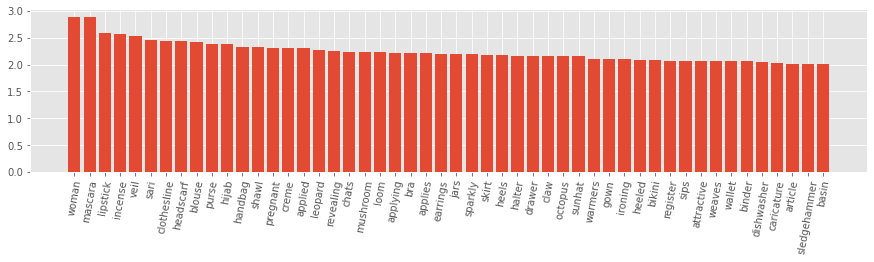

In [157]:
get_n_highest("woman", pmi_premise, n=50, plot=True, rotation=80, figsize=(15, 3))

In [158]:
get_pmi("woman", "short")

1.2897041463215553

In [159]:
get_pmi("man", "short")

0.2977975043483466

In [160]:
get_n_highest("man", pmi_premise, n=200, plot=False, rotation=80, figsize=(15, 3))

[(('man', 'man'), 1.9647533772668104),
 (('man', 'girlfriend'), 1.8867508652655374),
 (('man', 'mustached'), 1.8578381733502984),
 (('man', 'shaves'), 1.8578381733502984),
 (('man', 'breakdances'), 1.8492761598468743),
 (('man', 'necktie'), 1.8272498535168755),
 (('man', 'rearing'), 1.8272498535168755),
 (('man', 'balding'), 1.8162308525567223),
 (('man', 'beard'), 1.8093990743221224),
 (('man', 'bearded'), 1.7935667272605869),
 (('man', 'harmonica'), 1.789666670708719),
 (('man', 'mustache'), 1.7825500460460613),
 (('man', 'duffel'), 1.7423609559303623),
 (('man', 'tuning'), 1.7423609559303623),
 (('man', 'tuxedo'), 1.7208277943807213),
 (('man', 'goatee'), 1.7196408794302789),
 (('man', 'razor'), 1.7017189714330165),
 (('man', 'carves'), 1.7017189714330165),
 (('man', 'beret'), 1.6955667444514213),
 (('man', 'shined'), 1.684645458074075),
 (('man', 'turban'), 1.6752467600718255),
 (('man', 'spider'), 1.6752467600718255),
 (('man', 'undershirt'), 1.6651930954079026),
 (('man', 'lotter

### Man doing manly things

In [185]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'weapon' == j], key=lambda x: x[1], reverse=True)

[(('female', 'weapon'), 3.6329364263861903),
 (('asian', 'weapon'), 2.8557048923073007),
 (('male', 'weapon'), 2.541167128462618),
 (('old', 'weapon'), 2.3924490301029984),
 (('man', 'weapon'), 1.176257482460522),
 (('black', 'weapon'), -0.46793341438217134),
 (('young', 'weapon'), -0.6150504535590963),
 (('woman', 'weapon'), -1.3572307565819253)]

In [186]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'knife' == j], key=lambda x: x[1], reverse=True)

[(('mexican', 'knife'), 5.1440111487474764),
 (('male', 'knife'), 1.3461511460574749),
 (('man', 'knife'), 1.1942352233895777),
 (('white', 'knife'), 0.2259998129094386),
 (('young', 'knife'), 0.1899335640357607),
 (('black', 'knife'), -0.07798689606615793),
 (('asian', 'knife'), -0.3393110900978421),
 (('woman', 'knife'), -0.38232173754475557),
 (('girl', 'knife'), -0.7759061271572818),
 (('boy', 'knife'), -1.332053061778066),
 (('men', 'knife'), -1.3585974331473194),
 (('women', 'knife'), -1.5057216073639177)]

In [187]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'aiming' == j], key=lambda x: x[1], reverse=True)

[(('japanese', 'aiming'), 5.413761929319981),
 (('asian', 'aiming'), 2.016169564500547),
 (('female', 'aiming'), 1.7934010985794364),
 (('man', 'aiming'), 1.1992186309038333),
 (('boy', 'aiming'), 1.023427592820323),
 (('girls', 'aiming'), 0.824182800528455),
 (('young', 'aiming'), -0.4545857813658502),
 (('girl', 'aiming'), -1.005387973280049),
 (('black', 'aiming'), -1.3074687421889253),
 (('white', 'aiming'), -1.4185195324921722),
 (('woman', 'aiming'), -2.196766084388679)]

In [188]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'operates' == j], key=lambda x: x[1], reverse=True)

[(('male', 'operates'), 1.396777219127443),
 (('man', 'operates'), 1.2162921442627748),
 (('boys', 'operates'), 0.9482601599372589),
 (('young', 'operates'), 0.24055963710572884),
 (('woman', 'operates'), 0.08334183480405638),
 (('black', 'operates'), -0.027360822996189978),
 (('white', 'operates'), -0.13841161329943705),
 (('boy', 'operates'), -0.28142698870809807)]

In [189]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'hammer' == j], key=lambda x: x[1], reverse=True)

[(('teenager', 'hammer'), 3.494413217648179),
 (('elderly', 'hammer'), 2.916960859034302),
 (('teenage', 'hammer'), 2.384131162633268),
 (('indian', 'hammer'), 2.041123349627078),
 (('old', 'hammer'), 1.6745922588844968),
 (('boy', 'hammer'), 1.2325689906589146),
 (('man', 'hammer'), 1.227787783100604),
 (('young', 'hammer'), 0.7545556164727415),
 (('male', 'hammer'), -0.17668964275588367),
 (('white', 'hammer'), -0.29684097590392),
 (('black', 'hammer'), -0.3784352635430686),
 (('asian', 'hammer'), -0.8621518789112008),
 (('woman', 'hammer'), -0.9051625263581141),
 (('girls', 'hammer'), -1.0541386428832926),
 (('men', 'hammer'), -1.296475721239522),
 (('girl', 'hammer'), -1.8837094166917967)]

In [190]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'inspects' == j], key=lambda x: x[1], reverse=True)

[(('daughter', 'inspects'), 4.725424582387562),
 (('mother', 'inspects'), 3.528686749811283),
 (('old', 'inspects'), 2.430923177917634),
 (('man', 'inspects'), 1.2147316302751578),
 (('asian', 'inspects'), 0.8941790401219363),
 (('women', 'inspects'), -0.27223147714413926),
 (('woman', 'inspects'), -0.3187566087672893),
 (('young', 'inspects'), -0.5765763057444606),
 (('black', 'inspects'), -1.4294592665675354),
 (('white', 'inspects'), -1.5405100568707828)]

In [191]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'welds' == j], key=lambda x: x[1], reverse=True)

[(('man', 'welds'), 1.3367221546537682),
 (('boy', 'welds'), 0.023427592820323008),
 (('young', 'welds'), -0.4545857813658502)]

In [192]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'sculpting' == j], key=lambda x: x[1], reverse=True)

[(('male', 'sculpting'), 1.9311136467786312),
 (('man', 'sculpting'), 1.3546998955828236),
 (('asian', 'sculpting'), 1.245651410623314),
 (('white', 'sculpting'), 0.39592481435175114),
 (('black', 'sculpting'), -0.07798689606615793),
 (('woman', 'sculpting'), -0.38232173754475557)]

In [193]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'rifle' == j], key=lambda x: x[1], reverse=True)

[(('african', 'rifle'), 3.4230739628356703),
 (('man', 'rifle'), 1.410164525589173),
 (('asian', 'rifle'), 0.5490435540732488),
 (('young', 'rifle'), 0.0782882082068518),
 (('boy', 'rifle'), -0.4436984176069751),
 (('woman', 'rifle'), -1.0789295940948207),
 (('men', 'rifle'), -1.4702427889762286),
 (('black', 'rifle'), -1.7745947526162231)]

In [170]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'blowtorch' == j], key=lambda x: x[1], reverse=True)

[(('man', 'blowtorch'), 1.5497158779879665),
 (('women', 'blowtorch'), 0.9372218884848106),
 (('woman', 'blowtorch'), -0.10930324313833964)]

### Men smile less

In [171]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'smiling' == j], key=lambda x: x[1], reverse=True)

[(('sister', 'smiling'), 2.6258002939267033),
 (('buddhist', 'smiling'), 2.2107627946478594),
 (('caucasian', 'smiling'), 1.5227068009625997),
 (('hispanic', 'smiling'), 1.4737972004816533),
 (('daughter', 'smiling'), 1.4358293502826327),
 (('senior', 'smiling'), 1.2107627946478596),
 (('teenagers', 'smiling'), 1.1045633908159342),
 (('girls', 'smiling'), 1.06794887265747),
 (('women', 'smiling'), 0.9742261909911418),
 (('brother', 'smiling'), 0.954423041388074),
 (('girl', 'smiling'), 0.9264340925342256),
 (('woman', 'smiling'), 0.8212641233295175),
 (('asian', 'smiling'), 0.8062176691866579),
 (('young', 'smiling'), 0.7834439212140201),
 (('mexican', 'smiling'), 0.7659779519749637),
 (('mother', 'smiling'), 0.7245183448765956),
 (('boy', 'smiling'), 0.6562359556952372),
 (('asians', 'smiling'), 0.6527673415269726),
 (('teenager', 'smiling'), 0.639220809689025),
 (('son', 'smiling'), 0.6191365636456926),
 (('african', 'smiling'), 0.6161177405293641),
 (('father', 'smiling'), 0.5227068

# Hypotheses Analysis

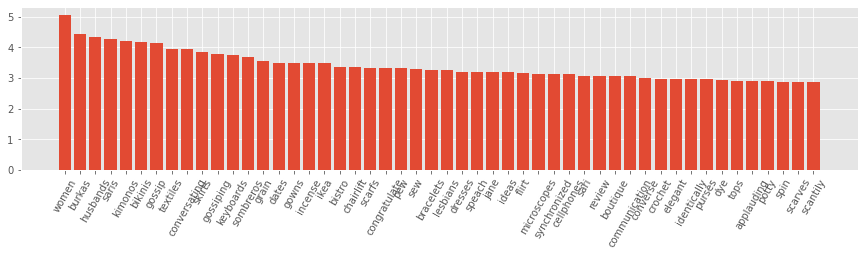

In [172]:
get_n_highest("women", pmi_hyp, n=50, plot=True, rotation=60, figsize=(15, 3))

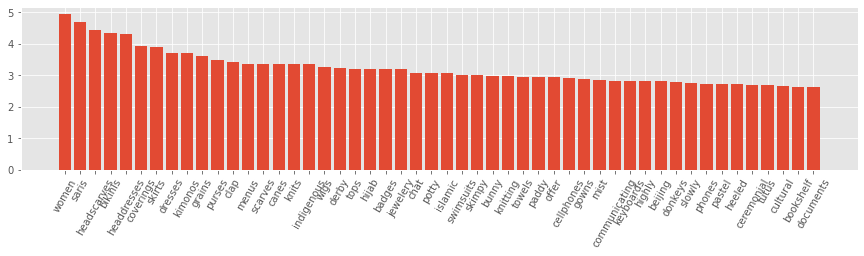

In [173]:
get_n_highest("women", pmi_premise, n=50, plot=True, rotation=60, figsize=(15, 3))

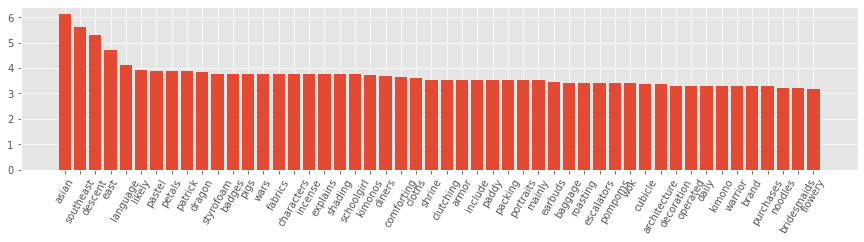

In [175]:
get_n_highest("asian", pmi_premise, n=50, plot=True, rotation=60, figsize=(15, 3))

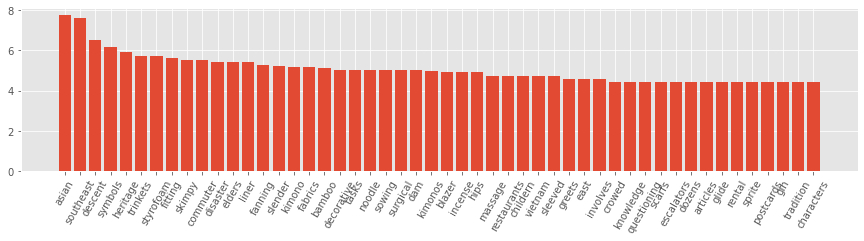

In [174]:
get_n_highest("asian", pmi_hyp, n=50, plot=True, rotation=60, figsize=(15, 3))

In [180]:
get_n_highest("asian", pmi_hyp, n=100, plot=False, rotation=60, figsize=(15, 3))

[(('asian', 'asian'), 7.739013696029451),
 (('asian', 'southeast'), 7.613482813945592),
 (('asian', 'descent'), 6.526019972695252),
 (('asian', 'symbols'), 6.154051195308295),
 (('asian', 'heritage'), 5.931658773971846),
 (('asian', 'trinkets'), 5.739013696029451),
 (('asian', 'styrofoam'), 5.739013696029451),
 (('asian', 'fitting'), 5.623536478609515),
 (('asian', 'skimpy'), 5.516621274693003),
 (('asian', 'commuter'), 5.516621274693003),
 (('asian', 'disaster'), 5.417085601142088),
 (('asian', 'elders'), 5.417085601142088),
 (('asian', 'liner'), 5.417085601142088),
 (('asian', 'fanning'), 5.279582077392154),
 (('asian', 'slender'), 5.236513355500268),
 (('asian', 'kimono'), 5.154051195308295),
 (('asian', 'fabrics'), 5.154051195308295),
 (('asian', 'bamboo'), 5.101583775414159),
 (('asian', 'decorative'), 5.038573977888358),
 (('asian', 'tasks'), 5.038573977888358),
 (('asian', 'noodle'), 5.038573977888358),
 (('asian', 'sowing'), 5.038573977888358),
 (('asian', 'surgical'), 5.038573

In [207]:
get_n_highest("asian", pmi_premise, n=100, plot=False, rotation=60, figsize=(15, 3))

[(('asian', 'asian'), 6.103632405750886),
 (('asian', 'southeast'), 5.618205578580644),
 (('asian', 'descent'), 5.308452197639384),
 (('asian', 'east'), 4.725120782497156),
 (('asian', 'language'), 4.103632405750886),
 (('asian', 'likely'), 3.9019985445812355),
 (('asian', 'pastel'), 3.8812399844144383),
 (('asian', 'petals'), 3.8812399844144383),
 (('asian', 'patrick'), 3.8812399844144383),
 (('asian', 'dragon'), 3.823524486558151),
 (('asian', 'styrofoam'), 3.7817043108635238),
 (('asian', 'badges'), 3.7817043108635238),
 (('asian', 'pigs'), 3.7817043108635238),
 (('asian', 'wars'), 3.7817043108635238),
 (('asian', 'fabrics'), 3.7817043108635238),
 (('asian', 'characters'), 3.7817043108635238),
 (('asian', 'incense'), 3.7817043108635238),
 (('asian', 'explains'), 3.7817043108635238),
 (('asian', 'shading'), 3.7817043108635238),
 (('asian', 'schoolgirl'), 3.7817043108635238),
 (('asian', 'kimonos'), 3.7113149829721257),
 (('asian', 'diners'), 3.6885949064720425),
 (('asian', 'comforti

In [208]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'gay' == i], key=lambda x: x[1], reverse=True)

[(('gay', 'gay'), 13.0317394872691),
 (('gay', 'pride'), 11.25413190860555),
 (('gay', 'marriage'), 10.224384565211496),
 (('gay', 'attendees'), 9.446776986547944),
 (('gay', 'protester'), 8.709811392381738),
 (('gay', 'maybe'), 8.387883297494376),
 (('gay', 'participants'), 8.331299769128009),
 (('gay', 'float'), 8.224384565211496),
 (('gay', 'fellow'), 7.63942206449034),
 (('gay', 'support'), 7.539886390939426),
 (('gay', 'topless'), 7.477150635591463),
 (('gay', 'celebrating'), 7.2768519851056315),
 (('gay', 'parade'), 7.0056771906829045),
 (('gay', 'attending'), 6.691889484384475),
 (('gay', 'tourist'), 6.622348551131399),
 (('gay', 'directions'), 6.605474732567003),
 (('gay', 'rainbow'), 6.461883878938153),
 (('gay', 'poster'), 6.317493969602978),
 (('gay', 'step'), 6.290272500867953),
 (('gay', 'surrounding'), 6.112876249994506),
 (('gay', 'appear'), 5.8222861216401505),
 (('gay', 'nice'), 5.7371187383774735),
 (('gay', 'festival'), 5.556006056302703),
 (('gay', 'happy'), 5.29027

In [212]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'christian' == i], key=lambda x: x[1], reverse=True)

[(('christian', 'christian'), 15.065443183151753),
 (('christian', 'strips'), 11.480480682430597),
 (('christian', 'stretched'), 10.42158699337703),
 (('christian', 'holidays'), 10.021049063793301),
 (('christian', 'celebrates'), 7.999353992693981),
 (('christian', 'presents'), 7.915696063647072),
 (('christian', 'accordion'), 7.915696063647072),
 (('christian', 'praying'), 7.271027316801648),
 (('christian', 'live'), 7.0598186339578755),
 (('christian', 'opening'), 6.831823506392052),
 (('christian', 'marching'), 6.614232071319425),
 (('christian', 'left'), 6.254871548410607),
 (('christian', 'practice'), 6.216820242722416),
 (('christian', 'scooter'), 6.1675977271462425),
 (('christian', 'christmas'), 5.817515669708168),
 (('christian', 'cross'), 5.7233685151526155),
 (('christian', 'church'), 5.105441251083673),
 (('christian', 'students'), 4.9195110373312385),
 (('christian', 'hand'), 4.599876778342355),
 (('christian', 'indoors'), 4.548758233842143),
 (('christian', 'floor'), 4.46

In [211]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'hell' == j], key=lambda x: x[1], reverse=True)

[(('asian', 'hell'), 3.9316587739718467),
 (('white', 'hell'), 2.385963083646308),
 (('girls', 'hell'), 2.278969337930452),
 (('black', 'hell'), 2.1765097180173583),
 (('boy', 'hell'), 0.6431155591771961),
 (('man', 'hell'), 0.11692385357942961),
 (('woman', 'hell'), -0.5503588497107819)]

In [214]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'muslim' == i], key=lambda x: x[1], reverse=True)

[(('muslim', 'muslim'), 12.850430292180903),
 (('muslim', 'pamphlets'), 9.762967450930564),
 (('muslim', 'mosque'), 9.68050529073859),
 (('muslim', 'peddling'), 9.043075370123299),
 (('muslim', 'aloud'), 9.043075370123299),
 (('muslim', 'worship'), 8.390998673543606),
 (('muslim', 'procession'), 7.992449297053332),
 (('muslim', 'stall'), 7.5105802892962785),
 (('muslim', 'turban'), 7.458112869402143),
 (('muslim', 'praying'), 7.37794252071816),
 (('muslim', 'jewish'), 7.295841440503266),
 (('muslim', 'garb'), 7.043075370123299),
 (('muslim', 'weapon'), 6.943539696572385),
 (('muslim', 'law'), 6.850430292180904),
 (('muslim', 'allowed'), 6.80603617282245),
 (('muslim', 'knees'), 6.5105802892962785),
 (('muslim', 'wares'), 6.5105802892962785),
 (('muslim', 'temple'), 6.192218809429109),
 (('muslim', 'handed'), 5.992449297053332),
 (('muslim', 'urban'), 5.919692954618017),
 (('muslim', 'check'), 5.546649544003801),
 (('muslim', 'scooter'), 5.537547336896548),
 (('muslim', 'service'), 5.48

In [215]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'muslim' == i], key=lambda x: x[1], reverse=True)

[(('muslim', 'muslim'), 11.84411248409333),
 (('muslim', 'creation'), 8.522184389205966),
 (('muslim', 'hijab'), 8.522184389205966),
 (('muslim', 'sands'), 8.522184389205966),
 (('muslim', 'islamic'), 8.384680865456032),
 (('muslim', 'loud'), 8.259149983372174),
 (('muslim', 'procession'), 8.143672765952237),
 (('muslim', 'desolate'), 8.143672765952237),
 (('muslim', 'wraps'), 8.143672765952237),
 (('muslim', 'temporary'), 7.93722188848481),
 (('muslim', 'populated'), 7.93722188848481),
 (('muslim', 'frowning'), 7.844112484093329),
 (('muslim', 'powder'), 7.75664964284299),
 (('muslim', 'praying'), 7.674187482651017),
 (('muslim', 'headscarves'), 7.451795061314569),
 (('muslim', 'bringing'), 7.451795061314569),
 (('muslim', 'styled'), 7.320550528036317),
 (('muslim', 'shines'), 7.089224981929861),
 (('muslim', 'ruins'), 6.986131488965757),
 (('muslim', 'hips'), 6.799718364734876),
 (('muslim', 'khakis'), 6.799718364734876),
 (('muslim', 'headdress'), 6.352259387763654),
 (('muslim', 't

In [217]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'jewish' == i], key=lambda x: x[1], reverse=True)

[(('jewish', 'jewish'), 13.318209253531721),
 (('jewish', 'glancing'), 9.996281158644358),
 (('jewish', 'hitler'), 9.318209253531721),
 (('jewish', 'armed'), 8.794647297474707),
 (('jewish', 'prays'), 8.674353063756996),
 (('jewish', 'symbol'), 8.617769535390629),
 (('jewish', 'david'), 8.510854331474116),
 (('jewish', 'god'), 8.14828425208941),
 (('jewish', 'bacon'), 8.070281740088134),
 (('jewish', 'guards'), 8.014428505354617),
 (('jewish', 'jesus'), 7.891944498829623),
 (('jewish', 'amount'), 7.826356157202046),
 (('jewish', 'traditional'), 7.72575221626364),
 (('jewish', 'attends'), 7.674353063756996),
 (('jewish', 'descent'), 7.645783911560225),
 (('jewish', 'fills'), 7.536849540007061),
 (('jewish', 'muslim'), 7.295841440503266),
 (('jewish', 'star'), 6.688852633452111),
 (('jewish', 'temple'), 6.659997770779926),
 (('jewish', 'hopscotch'), 6.5500249287547945),
 (('jewish', 'priest'), 6.447844533948316),
 (('jewish', 'grandfather'), 6.375694748192481),
 (('jewish', 'entertaining

In [219]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'jewish' == i], key=lambda x: x[1], reverse=True)

[(('jewish', 'jewish'), 12.394309566653808),
 (('jewish', 'guest'), 10.072381471766446),
 (('jewish', 'seaside'), 8.934877948016512),
 (('jewish', 'vacation'), 8.394309566653808),
 (('jewish', 'armed'), 7.693869848512716),
 (('jewish', 'shelter'), 7.63942206449034),
 (('jewish', 'prayer'), 7.536328571526236),
 (('jewish', 'fill'), 7.440113256266933),
 (('jewish', 'buffet'), 7.184856201024859),
 (('jewish', 'celebrate'), 7.10890734779156),
 (('jewish', 'guards'), 6.902456470324134),
 (('jewish', 'celebration'), 6.536328571526236),
 (('jewish', 'plates'), 6.054459563769184),
 (('jewish', 'order'), 6.001992143875048),
 (('jewish', 'star'), 5.902456470324134),
 (('jewish', 'dinner'), 5.847415106766172),
 (('jewish', 'meeting'), 5.574130604238621),
 (('jewish', 'bent'), 5.451795061314569),
 (('jewish', 'wine'), 5.296277483693282),
 (('jewish', 'family'), 5.221882058008326),
 (('jewish', 'button'), 5.2144004766388745),
 (('jewish', 'groom'), 5.127523025958907),
 (('jewish', 'seen'), 4.714829

In [177]:
def find_sentence(w1, w2, source="premise"):
    if source=="premise":
        sent = "sentence1"
    else:
        sent = "sentence2"
        
    res = set()
    count = 0
    for sentence in train[sent].values:
        if isinstance(sentence, float):
            continue
        if w1 in sentence and w2 in sentence:
            count += 1                
            res.add(sentence)
            
    return res

In [178]:
[x for x in train["sentence2"] if not isinstance(x, float) and "asian" in x and "skimpy" in x]

[]

# PMI ANALYSIS - PREMISE

**Gender**
- male/female
- man/woman
- men/women
- girl/boy

**Race**
- caucasian
- asian
- indian
- chinese
- black
- white
- african

**Religion**
- christian/s
- muslim/s
- jewish/jews
- buddhist/s
- sikh/s

**Age**
- young
- old
- elderly

## Gender

- male/female
- man/woman
- men/women
- girl/boy

### hypothesis - male/female

In [260]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'male' == i], key=lambda x: x[1], reverse=True)[:100]

[(('male', 'male'), 8.055814481953977),
 (('male', 'swallower'), 6.31884888778777),
 (('male', 'entry'), 5.733886387066614),
 (('male', 'dumps'), 5.470851981232821),
 (('male', 'youthful'), 5.470851981232821),
 (('male', 'vocalist'), 5.411958292179253),
 (('male', 'audiance'), 5.355374763812885),
 (('male', 'invention'), 5.355374763812885),
 (('male', 'descent'), 5.1907440620400855),
 (('male', 'conga'), 5.148923886345458),
 (('male', 'eyeglasses'), 5.055814481953977),
 (('male', 'adolescent'), 5.055814481953977),
 (('male', 'stripper'), 4.926531465009011),
 (('male', 'suspenders'), 4.833422060617529),
 (('male', 'practiced'), 4.807886968510392),
 (('male', 'dozens'), 4.733886387066614),
 (('male', 'perusing'), 4.733886387066614),
 (('male', 'per'), 4.733886387066614),
 (('male', 'june'), 4.733886387066614),
 (('male', 'lightly'), 4.733886387066614),
 (('male', 'companions'), 4.733886387066614),
 (('male', 'agents'), 4.733886387066614),
 (('male', 'mountainous'), 4.733886387066614),
 (

In [261]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'female' == i], key=lambda x: x[1], reverse=True)[:100]

[(('female', 'female'), 7.681121958856931),
 (('female', 'contortionist'), 6.359193863969568),
 (('female', 'consisting'), 6.096159458135774),
 (('female', 'tanned'), 5.681121958856931),
 (('female', 'slender'), 5.593659117606591),
 (('female', 'barista'), 5.543618435106995),
 (('female', 'rollerskaters'), 5.458729537520482),
 (('female', 'sharply'), 5.359193863969568),
 (('female', 'tummy'), 5.359193863969568),
 (('female', 'vocalist'), 5.359193863969568),
 (('female', 'sweatsuit'), 5.2216903402196335),
 (('female', 'consists'), 5.096159458135774),
 (('female', 'backstroke'), 4.873767036799326),
 (('female', 'latte'), 4.80665284094079),
 (('female', 'acrobat'), 4.788037162773443),
 (('female', 'technique'), 4.681121958856931),
 (('female', 'bra'), 4.565644741436994),
 (('female', 'possible'), 4.565644741436994),
 (('female', 'mma'), 4.511196957414618),
 (('female', 'violinist'), 4.484724746053427),
 (('female', 'olympian'), 4.433194445413345),
 (('female', 'breather'), 4.3591938639695

Observations
- male: sripper, perusing, fooling, chief, determined, protestor, conversating, ghetto, con
- female: slender, tummy, bra, revealing, servers, asssists, sew, youthful, protestor

### hypothesis - man/woman

In [262]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'man' == i], key=lambda x: x[1], reverse=True)[:100]

[(('man', 'man'), 2.339316274915878),
 (('man', 'beared'), 2.339316274915878),
 (('man', 'refueling'), 2.1873131814708273),
 (('man', 'mustache'), 2.12358758386044),
 (('man', 'shaven'), 2.1079907288094217),
 (('man', 'afro'), 2.1048510212788543),
 (('man', 'accepts'), 2.0983081754120825),
 (('man', 'propose'), 2.0983081754120825),
 (('man', 'bearded'), 2.057903339767229),
 (('man', 'hardhat'), 2.0344616933874566),
 (('man', 'shoeless'), 2.017388180028515),
 (('man', 'slung'), 2.017388180028515),
 (('man', 'grinder'), 2.017388180028515),
 (('man', 'harlequin'), 2.017388180028515),
 (('man', 'balding'), 1.9673474975289196),
 (('man', 'tongs'), 1.9608046516621476),
 (('man', 'chested'), 1.9608046516621476),
 (('man', 'shoeshine'), 1.9433875985847382),
 (('man', 'coconuts'), 1.9407668984256026),
 (('man', 'coffin'), 1.9242787756370336),
 (('man', 'feathered'), 1.9242787756370336),
 (('man', 'beard'), 1.8898687448512024),
 (('man', 'mustached'), 1.87988465627858),
 (('man', 'briefcase'), 1

In [263]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'woman' == i], key=lambda x: x[1], reverse=True)[:100]

[(('woman', 'woman'), 3.2569960723468223),
 (('woman', 'weaves'), 2.93506797745946),
 (('woman', 'chevrolet'), 2.8419585730679784),
 (('woman', 'veil'), 2.7715692451765803),
 (('woman', 'bra'), 2.7264813556480423),
 (('woman', 'applies'), 2.702407220669185),
 (('woman', 'sari'), 2.6720335716256662),
 (('woman', 'pantsuit'), 2.6720335716256662),
 (('woman', 'immigration'), 2.6720335716256662),
 (('woman', 'headscarf'), 2.6469425906628357),
 (('woman', 'shawl'), 2.6469425906628357),
 (('woman', 'mache'), 2.604919375767129),
 (('woman', 'injection'), 2.604919375767129),
 (('woman', 'handbag'), 2.5980329901818893),
 (('woman', 'lipstick'), 2.5741862482275213),
 (('woman', 'smock'), 2.55655635420573),
 (('woman', 'tiara'), 2.520030478180616),
 (('woman', 'pregnant'), 2.520030478180616),
 (('woman', 'quilts'), 2.520030478180616),
 (('woman', 'purse'), 2.509439066912901),
 (('woman', 'folds'), 2.4793884936832704),
 (('woman', 'sledgehammer'), 2.4793884936832704),
 (('woman', 'panties'), 2.479

Observation
- man: robs, boom, dragged, flirts, interviews, machete, operates, homeless, commiting, chainsaw, creepy, insane
- woman: bra, shawl, headscarf, injection, pregnant, panties, attractive, skirt, flirts, bikini, sexy, skimpy, lingerie, babysitting, knitting, flirting

### hypothesis - men/women

In [264]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'men' == i], key=lambda x: x[1], reverse=True)[:100]

[(('men', 'men'), 4.298381969314996),
 (('men', 'turbans'), 4.191466765398484),
 (('men', 'rickshaws'), 3.976453874427634),
 (('men', 'wives'), 3.850922992343775),
 (('men', 'cigars'), 3.5278638154377635),
 (('men', 'tuxedos'), 3.5207743906514444),
 (('men', 'rig'), 3.3914913737064776),
 (('men', 'beards'), 3.3914913737064776),
 (('men', 'kilts'), 3.2983819693149963),
 (('men', 'southeast'), 3.2983819693149963),
 (('men', 'gutters'), 3.234251631895281),
 (('men', 'jumpsuits'), 3.220379457313723),
 (('men', 'settle'), 3.1608784455650616),
 (('men', 'speedos'), 3.1057368913726005),
 (('men', 'guitars'), 3.0680843498932022),
 (('men', 'fatigues'), 3.050454455871411),
 (('men', 'hardhats'), 3.0353475634812024),
 (('men', 'banjos'), 3.0353475634812024),
 (('men', 'naval'), 3.0353475634812024),
 (('men', 'meditate'), 2.976453874427634),
 (('men', 'trumpets'), 2.959580055863238),
 (('men', 'tubas'), 2.9358118899302883),
 (('men', 'vests'), 2.8998325928247217),
 (('men', 'caps'), 2.89628352574

In [265]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'women' == i], key=lambda x: x[1], reverse=True)[:100]

[(('women', 'women'), 5.067356505302632),
 (('women', 'burkas'), 4.42992658468734),
 (('women', 'husbands'), 4.344890480831541),
 (('women', 'saris'), 4.2897489266390805),
 (('women', 'kimonos'), 4.219359598747682),
 (('women', 'bikinis'), 4.186938121055305),
 (('women', 'gossip'), 4.13774583319403),
 (('women', 'textiles'), 3.9518792878826963),
 (('women', 'conversating'), 3.9518792878826963),
 (('women', 'skirts'), 3.8449640839661843),
 (('women', 'gossiping'), 3.769675956661947),
 (('women', 'keyboards'), 3.7454284104152697),
 (('women', 'sombreros'), 3.6888448820489024),
 (('women', 'grain'), 3.5725918135530543),
 (('women', 'dates'), 3.482394004581476),
 (('women', 'gowns'), 3.482394004581476),
 (('women', 'incense'), 3.482394004581476),
 (('women', 'ikea'), 3.482394004581476),
 (('women', 'bistro'), 3.36691678716154),
 (('women', 'chairlift'), 3.36691678716154),
 (('women', 'scarfs'), 3.330390911136426),
 (('women', 'congratulate'), 3.330390911136426),
 (('women', 'pew'), 3.31246

Observations
- men: gutters, inappropriate, laptops, chemical, seminar, politics, dueling, swords, weapons, prefessionally, wrangle, mission, argue, discuss
- women: gossip, bikinis, gossiping, flirt, scantily, beauty, necklaces

### hypothesis - girl/boy

In [266]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'girl' == i], key=lambda x: x[1], reverse=True)[:100]

[(('girl', 'girl'), 4.40372869767462),
 (('girl', 'pigtails'), 3.988691198395776),
 (('girl', 'diary'), 3.666763103508414),
 (('girl', 'biscuits'), 3.5963737756170158),
 (('girl', 'fairy'), 3.40372869767462),
 (('girl', 'dolls'), 3.3747773239784906),
 (('girl', 'little'), 3.3452437315256778),
 (('girl', 'barbies'), 3.344835008621051),
 (('girl', 'daddy'), 3.325726185673347),
 (('girl', 'vine'), 3.2882514802546843),
 (('girl', 'braids'), 3.233803696232308),
 (('girl', 'wand'), 3.2020948365049695),
 (('girl', 'sticker'), 3.181336276338172),
 (('girl', 'doll'), 3.161158394400542),
 (('girl', 'symbols'), 3.140694291840826),
 (('girl', 'barbie'), 3.1011659276541885),
 (('girl', 'slingshot'), 3.0818006027872578),
 (('girl', 'switch'), 3.0818006027872578),
 (('girl', 'glittery'), 3.0818006027872578),
 (('girl', 'explorer'), 3.0818006027872578),
 (('girl', 'bearer'), 3.0818006027872578),
 (('girl', 'teeter'), 3.041158618289912),
 (('girl', 'totter'), 3.041158618289912),
 (('girl', 'mommy'), 3.

In [267]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'boy' == i], key=lambda x: x[1], reverse=True)[:100]

[(('boy', 'boy'), 4.450470481234801),
 (('boy', 'hacky'), 3.713504887068594),
 (('boy', 'scouts'), 3.6164804326737294),
 (('boy', 'scout'), 3.6122215512314124),
 (('boy', 'playroom'), 3.4504704812348),
 (('boy', 'cot'), 3.3129669574848655),
 (('boy', 'pumpkins'), 3.29846738778975),
 (('boy', 'floaties'), 3.2488366200651497),
 (('boy', 'farther'), 3.128542386347438),
 (('boy', 'pennies'), 3.128542386347438),
 (('boy', 'teenaged'), 3.0098978898488187),
 (('boy', 'cannonball'), 3.0098978898488187),
 (('boy', 'sparklers'), 3.0098978898488187),
 (('boy', 'dared'), 2.991038862597503),
 (('boy', 'hulk'), 2.991038862597503),
 (('boy', 'bases'), 2.9650436540645586),
 (('boy', 'stomps'), 2.9650436540645586),
 (('boy', 'piggy'), 2.9650436540645586),
 (('boy', 'little'), 2.933830409712129),
 (('boy', 'aunt'), 2.926908525177787),
 (('boy', 'pinata'), 2.918456860462603),
 (('boy', 'basketballs'), 2.865507980513644),
 (('boy', 'grins'), 2.865507980513644),
 (('boy', 'grounded'), 2.865507980513644),
 

nothing interesting

## Race

- caucasian
- asian
- indian
- chinese
- black
- white
- african

### hypothesis - caucasian

In [270]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'caucasian' == i], key=lambda x: x[1], reverse=True)[:100]

[(('caucasian', 'caucasian'), 11.977980341901414),
 (('caucasian', 'slender'), 9.890517500651075),
 (('caucasian', 'fleece'), 8.73005282845783),
 (('caucasian', 'festive'), 7.808055340459102),
 (('caucasian', 'zip'), 7.656052247014053),
 (('caucasian', 'non'), 7.585662919122655),
 (('caucasian', 'handsome'), 7.585662919122655),
 (('caucasian', 'defending'), 7.585662919122655),
 (('caucasian', 'auditioning'), 7.518548723264117),
 (('caucasian', 'iced'), 7.518548723264117),
 (('caucasian', 'heavyset'), 7.454418385844401),
 (('caucasian', 'arrival'), 7.277540623760323),
 (('caucasian', 'barrels'), 7.223092839737946),
 (('caucasian', 'spar'), 7.1199993467738425),
 (('caucasian', 'collect'), 6.808055340459102),
 (('caucasian', 'ipod'), 6.730052828457829),
 (('caucasian', 'wildly'), 6.730052828457829),
 (('caucasian', 'freezing'), 6.620428337283331),
 (('caucasian', 'mardi'), 6.585662919122655),
 (('caucasian', 'gras'), 6.454418385844401),
 (('caucasian', 'await'), 6.423391490223778),
 (('ca

caucasian: handsome, taught, purchases, instructor, nightclub, americaan, impress, teacher, rugby, blond, gentleman, protesting

### hypothesis - asian

In [275]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'asian' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('asian', 'asian'), 7.739013696029451),
 (('asian', 'southeast'), 7.613482813945592),
 (('asian', 'descent'), 6.526019972695252),
 (('asian', 'symbols'), 6.154051195308295),
 (('asian', 'heritage'), 5.931658773971846),
 (('asian', 'trinkets'), 5.739013696029451),
 (('asian', 'styrofoam'), 5.739013696029451),
 (('asian', 'fitting'), 5.623536478609515),
 (('asian', 'skimpy'), 5.516621274693003),
 (('asian', 'commuter'), 5.516621274693003),
 (('asian', 'disaster'), 5.417085601142088),
 (('asian', 'elders'), 5.417085601142088),
 (('asian', 'liner'), 5.417085601142088),
 (('asian', 'fanning'), 5.279582077392154),
 (('asian', 'slender'), 5.236513355500268),
 (('asian', 'kimono'), 5.154051195308295),
 (('asian', 'fabrics'), 5.154051195308295),
 (('asian', 'bamboo'), 5.101583775414159),
 (('asian', 'decorative'), 5.038573977888358),
 (('asian', 'tasks'), 5.038573977888358),
 (('asian', 'noodle'), 5.038573977888358),
 (('asian', 'sowing'), 5.038573977888358),
 (('asian', 'surgical'), 5.038573

asian: skimpy, disaster, elders, slender, knowledge, tradition, prostitutes, intoxicated, literature, playboy, employment, ceo, rowdy, 

In [276]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'asians' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('asians', 'asians'), 11.506475890963543),
 (('asians', 'tradition'), 8.18454779607618),
 (('asians', 'styles'), 7.921513390242386),
 (('asians', 'explain'), 7.921513390242386),
 (('asians', 'devoid'), 7.80603617282245),
 (('asians', 'receive'), 7.462081771605089),
 (('asians', 'holidays'), 7.462081771605089),
 (('asians', 'restraunt'), 7.184547796076179),
 (('asians', 'hosting'), 6.921513390242386),
 (('asians', 'cabinet'), 6.834050548992047),
 (('asians', 'barrels'), 6.751588388800074),
 (('asians', 'noodles'), 6.751588388800074),
 (('asians', 'media'), 6.751588388800074),
 (('asians', 'pokemon'), 6.599585295355023),
 (('asians', 'release'), 6.599585295355023),
 (('asians', 'mourning'), 6.552279580576667),
 (('asians', 'cartoons'), 6.462081771605089),
 (('asians', 'sauce'), 6.377192874018576),
 (('asians', 'strumming'), 6.33655088952123),
 (('asians', 'airplanes'), 6.297022525334592),
 (('asians', 'touring'), 6.297022525334592),
 (('asians', 'auto'), 6.297022525334592),
 (('asians'

In [274]:
[((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'asian' == i and j == 'ceo']

[(('asian', 'ceo'), 3.4910861825858652)]

asians: tradition, devoid, explain, mourning, airplanes, killing, everwhere, herd, exploring, china, chinese, company

### hypothesis - indian

In [281]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'indian' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('indian', 'indian'), 10.393017841180258),
 (('indian', 'southeast'), 8.393017841180258),
 (('indian', 'style'), 7.375095933182996),
 (('indian', 'boot'), 7.33412415212669),
 (('indian', 'muffins'), 7.071089746292896),
 (('indian', 'invited'), 7.071089746292896),
 (('indian', 'descent'), 7.042520594096125),
 (('indian', 'nights'), 6.933586222542961),
 (('indian', 'headache'), 6.933586222542961),
 (('indian', 'caption'), 6.933586222542961),
 (('indian', 'organization'), 6.808055340459102),
 (('indian', 'styles'), 6.808055340459102),
 (('indian', 'artifacts'), 6.808055340459102),
 (('indian', 'necks'), 6.808055340459102),
 (('indian', 'sari'), 6.808055340459102),
 (('indian', 'saris'), 6.808055340459102),
 (('indian', 'fitting'), 6.6925781230391665),
 (('indian', 'passionately'), 6.6925781230391665),
 (('indian', 'respective'), 6.6925781230391665),
 (('indian', 'leaders'), 6.6925781230391665),
 (('indian', 'guest'), 6.63813033901679),
 (('indian', 'veil'), 6.585662919122655),
 (('india

indian: passionately, heritage, saris, warrior, kidnapping, ritual, dmv, murder, serious, attacks, scary

In [278]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'murder' == j], key=lambda x: x[1], reverse=True)[:100]

[(('indian', 'murder'), 5.263734824235292),
 (('sister', 'murder'), 5.053517116844946),
 (('female', 'murder'), 2.551838941911964),
 (('man', 'murder'), 0.9104729761120031),
 (('woman', 'murder'), 0.12771305540185576),
 (('women', 'murder'), -0.06192651164233428),
 (('boy', 'murder'), -0.6788125357101664),
 (('men', 'murder'), -0.8309010476299702)]

In [280]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'attacks' == j], key=lambda x: x[1], reverse=True)[:100]

[(('french', 'attacks'), 6.673125760372994),
 (('indian', 'attacks'), 5.0007004184014985),
 (('american', 'attacks'), 4.237306698957647),
 (('white', 'attacks'), 1.8010005829251516),
 (('young', 'attacks'), 0.6838326410167529),
 (('man', 'attacks'), -0.4680386471417267),
 (('boy', 'attacks'), -0.9418469415439602),
 (('woman', 'attacks'), -1.135321350431938)]

In [282]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'scary' == j], key=lambda x: x[1], reverse=True)[:100]

[(('indian', 'scary'), 4.808055340459102),
 (('son', 'scary'), 3.7593814937234127),
 (('mother', 'scary'), 2.2373066989576467),
 (('female', 'scary'), 2.0961594581357743),
 (('girls', 'scary'), 1.5013617592669),
 (('women', 'scary'), 1.0673565053026322),
 (('white', 'scary'), 0.6083555049827557),
 (('young', 'scary'), 0.49118756307435707),
 (('woman', 'scary'), 0.2569960723468224),
 (('man', 'scary'), 0.21378539283201842),
 (('girl', 'scary'), -0.18123380304653625)]

### hypothesis - chinese

In [284]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'chinese' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('chinese', 'chinese'), 10.17583057897507),
 (('chinese', 'lanterns'), 8.14020666924435),
 (('chinese', 'squash'), 7.853902484087708),
 (('chinese', 'characters'), 7.590868078253915),
 (('chinese', 'takeout'), 7.475390860833979),
 (('chinese', 'gazebo'), 7.30136146105893),
 (('chinese', 'featuring'), 7.175830578975071),
 (('chinese', 'dragon'), 6.837960940218687),
 (('chinese', 'storefronts'), 6.716398960337774),
 (('chinese', 'refreshing'), 6.716398960337774),
 (('chinese', 'baton'), 6.683977482645396),
 (('chinese', 'ill'), 6.590868078253915),
 (('chinese', 'solve'), 6.590868078253915),
 (('chinese', 'trinkets'), 6.590868078253915),
 (('chinese', 'symbols'), 6.590868078253915),
 (('chinese', 'chinatown'), 6.531974389200347),
 (('chinese', 'chi'), 6.475390860833979),
 (('chinese', 'cheeks'), 6.420943076811603),
 (('chinese', 'peddling'), 6.368475656917467),
 (('chinese', 'aloud'), 6.368475656917467),
 (('chinese', 'bundles'), 6.368475656917467),
 (('chinese', 'competed'), 6.36847565

chinese: aloud, competed, employyment, garb, smashes, celebration, target, burned, asians, lazy, shooting

In [285]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'lazy' == j], key=lambda x: x[1], reverse=True)[:100]

[(('retired', 'lazy'), 7.85738305282267),
 (('chinese', 'lazy'), 3.683977482645396),
 (('teenagers', 'lazy'), 3.5136662691700216),
 (('father', 'lazy'), 2.9609848310317943),
 (('female', 'lazy'), 2.1892688625272556),
 (('male', 'lazy'), 1.5639613856243024),
 (('mother', 'lazy'), 1.3304161033491282),
 (('old', 'lazy'), 1.059862490869642),
 (('men', 'lazy'), 0.9764538744276341),
 (('man', 'lazy'), 0.3710251346432156),
 (('boys', 'lazy'), 0.03332364031154866),
 (('boy', 'lazy'), -0.04138261509487446),
 (('white', 'lazy'), -0.2985350906257628),
 (('young', 'lazy'), -0.4157030325341615),
 (('girl', 'lazy'), -0.5031618979338985),
 (('black', 'lazy'), -0.5079884562547127),
 (('woman', 'lazy'), -0.6498945232616963)]

In [287]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'shooting' == j], key=lambda x: x[1], reverse=True)[:100]

[(('mongolian', 'shooting'), 7.000123224938752),
 (('africans', 'shooting'), 4.964499315208031),
 (('chinese', 'shooting'), 3.210046294312984),
 (('sister', 'shooting'), 1.6320533484066693),
 (('boys', 'shooting'), 1.1443549527002927),
 (('father', 'shooting'), 0.9020911419782257),
 (('boy', 'shooting'), 0.5435798856262818),
 (('young', 'shooting'), 0.52540327841227),
 (('male', 'shooting'), 0.5050676965707338),
 (('men', 'shooting'), 0.5025226860952217),
 (('man', 'shooting'), 0.4032793336478424),
 (('woman', 'shooting'), -0.1644676960914544),
 (('son', 'shooting'), -0.20640279093867447),
 (('girls', 'shooting'), -0.46442252539518686),
 (('women', 'shooting'), -0.4833902800806109),
 (('mother', 'shooting'), -0.7284775857044404),
 (('asian', 'shooting'), -0.8117330893537925),
 (('female', 'shooting'), -0.8696248265263129),
 (('girl', 'shooting'), -0.9770930862663108),
 (('black', 'shooting'), -0.9819196445871249),
 (('white', 'shooting'), -1.3574287796793312),
 (('old', 'shooting'), -1

### hypothesis - black

In [288]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'black' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('black', 'black'), 5.983864640074962),
 (('black', 'smock'), 5.090779843991474),
 (('black', 'belts'), 4.880771147110859),
 (('black', 'saucer'), 4.831861546629912),
 (('black', 'labs'), 4.813939638632649),
 (('black', 'adidas'), 4.5688271407961185),
 (('black', 'sash'), 4.320899627352532),
 (('black', 'tights'), 4.291986935437294),
 (('black', 'rimmed'), 4.176509718017358),
 (('black', 'vibrant'), 4.176509718017358),
 (('black', 'beak'), 4.176509718017358),
 (('black', 'viewer'), 4.176509718017358),
 (('black', 'beret'), 4.118794220161071),
 (('black', 'hoods'), 4.109395522158821),
 (('black', 'friday'), 4.099341857494898),
 (('black', 'cloak'), 3.9838646400749624),
 (('black', 'spandex'), 3.9838646400749624),
 (('black', 'overturned'), 3.9838646400749624),
 (('black', 'adorned'), 3.9838646400749624),
 (('black', 'bangs'), 3.9838646400749624),
 (('black', 'belt'), 3.9443362758883245),
 (('black', 'labrador'), 3.9215803618206198),
 (('black', 'leggings'), 3.9134753121835644),
 (('bl

black: ghetto, digger, stripped, footballer, sexy, robbed, thieves, satan, viciously, commit

In [301]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'robbers' in j], key=lambda x: x[1], reverse=True)[:100]

[(('boys', 'robbers'), 3.847104831528586),
 (('asian', 'robbers'), 2.739013696029451),
 (('men', 'robbers'), 0.8833444700361527),
 (('boy', 'robbers'), 0.4504704812348002),
 (('young', 'robbers'), 0.07615006379551324),
 (('women', 'robbers'), 0.06735650530263224),
 (('girl', 'robbers'), -0.5962713023253801),
 (('man', 'robbers'), -1.6606837250841224)]

In [302]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'robbed' in j], key=lambda x: x[1], reverse=True)[:100]

[(('black', 'robbed'), 2.710846145668546),
 (('old', 'robbed'), 2.6937345920717446),
 (('boys', 'robbed'), 1.6671957415136514),
 (('girls', 'robbed'), 1.2283432648604842),
 (('young', 'robbed'), 1.2181690686679412),
 (('man', 'robbed'), 1.1817749979293974),
 (('men', 'robbed'), 0.44040097418742435),
 (('women', 'robbed'), 0.20937551017505993),
 (('woman', 'robbed'), -0.016022422059593686),
 (('boy', 'robbed'), -0.407510513892772)]

In [291]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'thieves' == j], key=lambda x: x[1], reverse=True)[:100]

[(('black', 'thieves'), 2.6619365451876),
 (('men', 'thieves'), 0.9764538744276341),
 (('man', 'thieves'), -0.982611819971485)]

In [292]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'satan' == j], key=lambda x: x[1], reverse=True)[:100]

[(('black', 'satan'), 2.6619365451876),
 (('girl', 'satan'), 1.0818006027872575),
 (('man', 'satan'), -0.982611819971485)]

In [298]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'viciously' in j], key=lambda x: x[1], reverse=True)[:100]

[(('black', 'viciously'), 2.6619365451876),
 (('woman', 'viciously'), 0.93506797745946)]

In [299]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'commit' in j], key=lambda x: x[1], reverse=True)[:100]

[(('boys', 'committing'), 3.203248641753861),
 (('white', 'committing'), 2.8713899108165495),
 (('black', 'commit'), 2.524433021437665),
 (('women', 'commit'), 1.6079248866653348),
 (('man', 'committing'), 1.6023506807496712),
 (('man', 'committed'), 1.017388180028515),
 (('boy', 'commit'), 0.9910388625975028),
 (('men', 'committing'), 0.9764538744276341),
 (('girl', 'commit'), 0.9442970790373226),
 (('men', 'commit'), 0.8389503506776991),
 (('man', 'commit'), 0.4648471569997365),
 (('woman', 'commit'), -0.20243554629047492)]

In [297]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'arrest' in j], key=lambda x: x[1], reverse=True)[:100]

[(('american', 'arrested'), 4.563534931278634),
 (('african', 'arrested'), 3.8467069826835045),
 (('elderly', 'arresting'), 3.5337832369592777),
 (('male', 'arrest'), 3.055814481953977),
 (('male', 'arresting'), 3.0114203625955236),
 (('female', 'arrest'), 2.6811219588569304),
 (('female', 'arresting'), 2.636727839498477),
 (('black', 'arresting'), 1.9394705207165086),
 (('old', 'arrested'), 1.4856263967415442),
 (('black', 'arrest'), 0.9838646400749622),
 (('man', 'arrested'), 0.9736668025991972),
 (('men', 'arrest'), 0.8833444700361527),
 (('young', 'arrested'), 0.595023374058897),
 (('woman', 'arrested'), 0.19090688188904978),
 (('man', 'arrest'), 0.14667119697348147),
 (('white', 'arrested'), 0.12722881524613947),
 (('young', 'arrest'), 0.07615006379551324),
 (('women', 'arrest'), 0.06735650530263224),
 (('women', 'arrested'), 0.0012673148448596489),
 (('man', 'arresting'), -0.12011534372141985),
 (('boy', 'arresting'), -0.5939236381236533),
 (('woman', 'arrest'), -0.74300392765317

### hypothesis - white

In [304]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'white' == i], key=lambda x: x[1], reverse=True)[:100]

[(('white', 'white'), 6.193318005703912),
 (('white', 'rodent'), 5.193318005703912),
 (('white', 'vertically'), 5.077840788283976),
 (('white', 'beak'), 4.970925584367464),
 (('white', 'padded'), 4.608355504982756),
 (('white', 'frosting'), 4.515246100591274),
 (('white', 'stripe'), 4.385963083646308),
 (('white', 'rafting'), 4.356816737986792),
 (('white', 'sleeve'), 4.279047879729796),
 (('white', 'overturned'), 4.193318005703912),
 (('white', 'stepped'), 4.193318005703912),
 (('white', 'flowered'), 4.193318005703912),
 (('white', 'wetsuits'), 4.193318005703912),
 (('white', 'squat'), 4.193318005703912),
 (('white', 'pillars'), 4.134424316650343),
 (('white', 'bottoms'), 4.105855164453573),
 (('white', 'stallion'), 4.077840788283976),
 (('white', 'twirl'), 4.077840788283976),
 (('white', 'spots'), 4.06993559019863),
 (('white', 'spotted'), 4.0233930042615995),
 (('white', 'stripes'), 3.970925584367464),
 (('white', 'refreshments'), 3.970925584367464),
 (('white', 'fluffy'), 3.9709255

### hypothesis - african

In [305]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'african' == i], key=lambda x: x[1], reverse=True)[:100]

[(('african', 'african'), 9.912796173141277),
 (('african', 'american'), 8.284332033783535),
 (('african', 'headstand'), 8.17583057897507),
 (('african', 'safari'), 8.005905577532758),
 (('african', 'descent'), 7.410295832612094),
 (('african', 'accompanied'), 7.3278336724201205),
 (('african', 'americans'), 7.280527957641764),
 (('african', 'marry'), 7.105441251083673),
 (('african', 'culture'), 6.8253333318909375),
 (('african', 'mango'), 6.590868078253915),
 (('african', 'grain'), 6.543562363475558),
 (('african', 'flotation'), 6.45336455450398),
 (('african', 'alphabet'), 6.45336455450398),
 (('african', 'organization'), 6.3278336724201205),
 (('african', 'poverty'), 6.3278336724201205),
 (('african', 'reaction'), 6.3278336724201205),
 (('african', 'styrofoam'), 6.3278336724201205),
 (('african', 'schoolwork'), 6.3278336724201205),
 (('african', 'chanting'), 6.212356455000185),
 (('african', 'chemical'), 6.212356455000185),
 (('african', 'century'), 6.212356455000185),
 (('african'

In [306]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'africans' == i], key=lambda x: x[1], reverse=True)[:100]

[(('africans', 'africans'), 13.515246100591275),
 (('africans', 'source'), 9.267318587147688),
 (('africans', 'armed'), 8.991684144534261),
 (('africans', 'mine'), 8.760358598427805),
 (('africans', 'die'), 8.760358598427805),
 (('africans', 'cloths'), 8.515246100591275),
 (('africans', 'tribal'), 8.470851981232821),
 (('africans', 'forced'), 8.305792734962324),
 (('africans', 'rights'), 8.157694095973191),
 (('africans', 'weapons'), 8.088981345889176),
 (('africans', 'diamond'), 8.0233930042616),
 (('africans', 'homes'), 7.707891178533671),
 (('africans', 'zebra'), 7.5379661770913575),
 (('africans', 'america'), 7.2298438817290265),
 (('africans', 'native'), 7.1576940959731905),
 (('africans', 'ten'), 7.064034988758945),
 (('africans', 'guns'), 7.039512669624877),
 (('africans', 'travel'), 6.900536256476066),
 (('africans', 'rice'), 6.747061775814348),
 (('africans', 'shelter'), 6.733886387066614),
 (('africans', 'bananas'), 6.584508763028388),
 (('africans', 'loud'), 6.48182309905382

african/s: guns, poverty, ghetto, jaywalking, secluded, warrior, die, forced

In [307]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'gun' in j], key=lambda x: x[1], reverse=True)[:100]

[(('africans', 'guns'), 7.039512669624877),
 (('retired', 'guns'), 6.873502718185947),
 (('russian', 'guns'), 6.873502718185947),
 (('elderly', 'shotgun'), 5.330249842874146),
 (('japanese', 'gun'), 3.126861229560266),
 (('straight', 'gun'), 3.096699259050013),
 (('boys', 'guns'), 3.0494433056748256),
 (('african', 'gun'), 2.316606416996867),
 (('old', 'shotgun'), 2.303788073755731),
 (('boys', 'shotgun'), 2.277249223197638),
 (('men', 'guns'), 1.992573539790911),
 (('old', 'gun'), 1.5404883317760625),
 (('boy', 'gun'), 1.468990569205598),
 (('man', 'shotgun'), 1.4133168563596543),
 (('man', 'handgun'), 1.0762818690820835),
 (('male', 'gun'), 1.044587226530723),
 (('elderly', 'gun'), 0.9819876001733208),
 (('girls', 'guns'), 0.9325189239090208),
 (('man', 'gun'), 0.9029978555498566),
 (('boy', 'handgun'), 0.8655079805136441),
 (('father', 'gun'), 0.8566481712170587),
 (('young', 'shotgun'), 0.8282225503519277),
 (('son', 'gun'), 0.7481542383001585),
 (('asian', 'gun'), 0.72778644060619

In [310]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'dies' == j], key=lambda x: x[1], reverse=True)[:100]

[(('american', 'dies'), 5.929184403595315),
 (('male', 'dies'), 4.355374763812885),
 (('woman', 'dies'), 0.55655635420573),
 (('man', 'dies'), -0.3611234432252148)]

## Religion
- christian/s
- muslim/s
- jewish/jews
- buddhist/s
- sikh/s

### hypothesis - christian/s

In [313]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'christian' in i], key=lambda x: x[1], reverse=True)[:100]

[(('christians', 'christians'), 15.550870010321995),
 (('christian', 'christian'), 15.065443183151753),
 (('christians', 'muslims'), 12.091438391684699),
 (('christians', 'gospel'), 11.850430292180903),
 (('christians', 'impressed'), 11.743515088264392),
 (('christian', 'strips'), 11.480480682430597),
 (('christians', 'pork'), 10.643979414713478),
 (('christians', 'villagers'), 10.463407169071656),
 (('christian', 'stretched'), 10.42158699337703),
 (('christian', 'holidays'), 10.021049063793301),
 (('christians', 'lobster'), 9.96590750960084),
 (('christians', 'campfire'), 8.431928937598489),
 (('christian', 'celebrates'), 7.999353992693981),
 (('christian', 'presents'), 7.915696063647072),
 (('christian', 'accordion'), 7.915696063647072),
 (('christians', 'sing'), 7.626057506716215),
 (('christian', 'praying'), 7.271027316801648),
 (('christians', 'used'), 7.171491643250733),
 (('christian', 'live'), 7.0598186339578755),
 (('christian', 'opening'), 6.831823506392052),
 (('christian', 

christian: strips, church, home, holidays, christmas

### hypothesis - muslim/s

In [312]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'muslim' in i], key=lambda x: x[1], reverse=True)[:100]

[(('muslims', 'muslims'), 15.41336648657206),
 (('muslim', 'muslim'), 12.850430292180903),
 (('muslims', 'christians'), 12.091438391684699),
 (('muslims', 'terrorists'), 12.091438391684699),
 (('muslim', 'pamphlets'), 9.762967450930564),
 (('muslim', 'mosque'), 9.68050529073859),
 (('muslims', 'celebrate'), 9.23014466251629),
 (('muslim', 'peddling'), 9.043075370123299),
 (('muslim', 'aloud'), 9.043075370123299),
 (('muslims', 'opening'), 8.764709310533515),
 (('muslim', 'worship'), 8.390998673543606),
 (('muslims', 'phones'), 8.064638332340984),
 (('muslim', 'procession'), 7.992449297053332),
 (('muslims', 'skateboards'), 7.726865959388842),
 (('muslims', 'local'), 7.616786036108632),
 (('muslim', 'stall'), 7.5105802892962785),
 (('muslim', 'turban'), 7.458112869402143),
 (('muslim', 'praying'), 7.37794252071816),
 (('muslim', 'jewish'), 7.295841440503266),
 (('muslim', 'garb'), 7.043075370123299),
 (('muslims', 'marching'), 6.962155374739732),
 (('muslim', 'weapon'), 6.94353969657238

In [314]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'weapon' == j], key=lambda x: x[1], reverse=True)[:100]

[(('muslim', 'weapon'), 6.943539696572385),
 (('elderly', 'weapon'), 2.6712867607092123),
 (('male', 'weapon'), 2.1489238863454583),
 (('female', 'weapon'), 1.774231363248412),
 (('man', 'weapon'), 1.0762818690820835),
 (('young', 'weapon'), 0.7542219689081509),
 (('girls', 'weapon'), 0.17943366437953787),
 (('boy', 'weapon'), 0.1285423863474378),
 (('black', 'weapon'), 0.0769740444664437),
 (('woman', 'weapon'), -0.327966428374334),
 (('girl', 'weapon'), -0.5031618979338985)]

In [315]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'dead' == j], key=lambda x: x[1], reverse=True)[:100]

[(('muslim', 'dead'), 4.366614514916647),
 (('indian', 'dead'), 1.909202063916002),
 (('teenager', 'dead'), 1.842087868057465),
 (('mother', 'dead'), 1.3384534224145463),
 (('old', 'dead'), 0.8752547319926642),
 (('daughter', 'dead'), 0.28963451754190855),
 (('boy', 'dead'), 0.21458221741412917),
 (('elderly', 'dead'), 0.09436157905347445),
 (('boys', 'dead'), 0.04136095937696716),
 (('white', 'dead'), 0.031430323327017874),
 (('father', 'dead'), -0.030977849902787423),
 (('man', 'dead'), -0.2376089067398604),
 (('young', 'dead'), -0.23774071202643077),
 (('girl', 'dead'), -0.2727321575320324),
 (('men', 'dead'), -0.2785432123407415),
 (('women', 'dead'), -0.4164592719616243),
 (('black', 'dead'), -0.4999511371892943),
 (('woman', 'dead'), -0.5829635151427094),
 (('asian', 'dead'), -0.7448020812348057),
 (('girls', 'dead'), -1.3974915172762001)]

In [317]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'terrorist' in j], key=lambda x: x[1], reverse=True)[:100]

[(('muslims', 'terrorists'), 12.091438391684699),
 (('american', 'terrorist'), 5.307696026849045),
 (('men', 'terrorists'), 0.9764538744276341),
 (('young', 'terrorist'), 0.7542219689081509),
 (('boy', 'terrorist'), 0.1285423863474378),
 (('man', 'terrorist'), 0.017388180028515037),
 (('man', 'terrorists'), -0.982611819971485),
 (('woman', 'terrorist'), -1.06493202254054)]

muslim/s: erroorists, weapon, temple, headed, laying, dead, body

### hypothesis - jewish/jews

In [318]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'jewish' == i], key=lambda x: x[1], reverse=True)[:100]

[(('jewish', 'jewish'), 13.318209253531721),
 (('jewish', 'glancing'), 9.996281158644358),
 (('jewish', 'hitler'), 9.318209253531721),
 (('jewish', 'armed'), 8.794647297474707),
 (('jewish', 'prays'), 8.674353063756996),
 (('jewish', 'symbol'), 8.617769535390629),
 (('jewish', 'david'), 8.510854331474116),
 (('jewish', 'god'), 8.14828425208941),
 (('jewish', 'bacon'), 8.070281740088134),
 (('jewish', 'guards'), 8.014428505354617),
 (('jewish', 'jesus'), 7.891944498829623),
 (('jewish', 'amount'), 7.826356157202046),
 (('jewish', 'traditional'), 7.72575221626364),
 (('jewish', 'attends'), 7.674353063756996),
 (('jewish', 'descent'), 7.645783911560225),
 (('jewish', 'fills'), 7.536849540007061),
 (('jewish', 'muslim'), 7.295841440503266),
 (('jewish', 'star'), 6.688852633452111),
 (('jewish', 'temple'), 6.659997770779926),
 (('jewish', 'hopscotch'), 6.5500249287547945),
 (('jewish', 'priest'), 6.447844533948316),
 (('jewish', 'grandfather'), 6.375694748192481),
 (('jewish', 'entertaining

### hypothesis - buddhist/s

In [319]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'buddhist' == i], key=lambda x: x[1], reverse=True)[:100]

[(('buddhist', 'buddhist'), 14.172358387068266),
 (('buddhist', 'feather'), 11.58739588634711),
 (('buddhist', 'thai'), 11.365003465010663),
 (('buddhist', 'temple'), 11.099109405037627),
 (('buddhist', 'monks'), 9.780040964289505),
 (('buddhist', 'monk'), 9.49053434709452),
 (('buddhist', 'wires'), 9.49053434709452),
 (('buddhist', 'pray'), 9.043075370123299),
 (('buddhist', 'gesture'), 8.58739588634711),
 (('buddhist', 'greet'), 8.471918668927174),
 (('buddhist', 'goodbye'), 8.471918668927174),
 (('buddhist', 'telephone'), 8.301993667484862),
 (('buddhist', 'meditating'), 8.289715337706424),
 (('buddhist', 'surrounding'), 7.680505290738592),
 (('buddhist', 'calm'), 7.557648542953058),
 (('buddhist', 'priest'), 7.301993667484862),
 (('buddhist', 'quietly'), 6.873150368680987),
 (('buddhist', 'traffic'), 6.843683459740318),
 (('buddhist', 'phones'), 6.823630232837188),
 (('buddhist', 'every'), 6.823630232837188),
 (('buddhist', 'stopped'), 6.594929559032518),
 (('buddhist', 'waving'), 

### hypothesis - sikh/s

In [255]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'sikh' == i], key=lambda x: x[1], reverse=True)[:100]

[]

## Age
- young
- old
- elderly

### hypothesis - young

In [320]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'young' == i], key=lambda x: x[1], reverse=True)[:100]

[(('young', 'young'), 5.076150063795513),
 (('young', 'sparing'), 3.8131156579617196),
 (('young', 'lad'), 3.796042144602778),
 (('young', 'reddish'), 3.754221968908151),
 (('young', 'bib'), 3.6611125645166696),
 (('young', 'solders'), 3.6167184451582157),
 (('young', 'sesame'), 3.6167184451582157),
 (('young', 'starfish'), 3.6167184451582157),
 (('young', 'biscuits'), 3.5907232366252715),
 (('young', 'hairstyle'), 3.3980781586828757),
 (('young', 'rickshaws'), 3.339184469629307),
 (('young', 'trousers'), 3.339184469629307),
 (('young', 'alphabet'), 3.2016809458793722),
 (('young', 'dandelions'), 3.2016809458793722),
 (('young', 'mand'), 3.2016809458793722),
 (('young', 'camouflaged'), 3.2016809458793722),
 (('young', 'cot'), 3.2016809458793722),
 (('young', 'twirls'), 3.1692594681869948),
 (('young', 'aims'), 3.1375506084596565),
 (('young', 'experiments'), 3.076150063795513),
 (('young', 'tidal'), 3.076150063795513),
 (('young', 'backward'), 3.076150063795513),
 (('young', 'markings'

In [321]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'old' == i], key=lambda x: x[1], reverse=True)[:100]

[(('old', 'old'), 6.5517155871993165),
 (('old', 'fashioned'), 6.487585249779601),
 (('old', 'reminisce'), 6.229787492311954),
 (('old', 'years'), 5.721640588641629),
 (('old', 'year'), 5.492821898145748),
 (('old', 'immigration'), 4.96675308647816),
 (('old', 'textile'), 4.814749993033111),
 (('old', 'age'), 4.595658934786914),
 (('old', 'coffin'), 4.5517155871993165),
 (('old', 'ferret'), 4.481326259307918),
 (('old', 'accepts'), 4.436238369779381),
 (('old', 'biscuits'), 4.329323165862869),
 (('old', 'knits'), 4.229787492311954),
 (('old', 'polishes'), 4.229787492311954),
 (('old', 'hooked'), 4.229787492311954),
 (('old', 'chapel'), 4.229787492311954),
 (('old', 'sideways'), 4.229787492311954),
 (('old', 'fourteen'), 4.229787492311954),
 (('old', 'memories'), 4.229787492311954),
 (('old', 'vases'), 4.229787492311954),
 (('old', 'inappropriate'), 4.092283968562019),
 (('old', 'carring'), 4.092283968562019),
 (('old', 'memory'), 4.092283968562019),
 (('old', 'root'), 4.092283968562019

In [322]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'elderly' == i], key=lambda x: x[1], reverse=True)[:100]

[(('elderly', 'elderly'), 8.578177356317731),
 (('elderly', 'antiques'), 6.578177356317731),
 (('elderly', 'casserole'), 6.256249261430368),
 (('elderly', 'floppy'), 6.256249261430368),
 (('elderly', 'immigration'), 5.993214855596575),
 (('elderly', 'retirement'), 5.770822434260127),
 (('elderly', 'biscuits'), 5.770822434260127),
 (('elderly', 'clutches'), 5.490714515067392),
 (('elderly', 'assisting'), 5.490714515067392),
 (('elderly', 'graveyard'), 5.330249842874146),
 (('elderly', 'shotgun'), 5.330249842874146),
 (('elderly', 'grandchildren'), 5.256249261430368),
 (('elderly', 'shock'), 5.256249261430368),
 (('elderly', 'perusing'), 5.256249261430368),
 (('elderly', 'speakers'), 5.256249261430368),
 (('elderly', 'cavity'), 5.256249261430368),
 (('elderly', 'gin'), 5.256249261430368),
 (('elderly', 'poison'), 5.256249261430368),
 (('elderly', 'shepherds'), 5.256249261430368),
 (('elderly', 'advantage'), 5.256249261430368),
 (('elderly', 'purposes'), 5.256249261430368),
 (('elderly', 

In [323]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'teenage' in i], key=lambda x: x[1], reverse=True)[:100]

[(('teenage', 'teenage'), 10.953934867934763),
 (('teenager', 'teenager'), 10.325903645321722),
 (('teenagers', 'teenagers'), 10.005519365499696),
 (('teenage', 'turtles'), 8.368972367213606),
 (('teenager', 'camouflaged'), 7.866472026684424),
 (('teenager', 'surfed'), 7.625463927180629),
 (('teenage', 'ninja'), 7.59638286331668),
 (('teenage', 'root'), 7.494503249297466),
 (('teenage', 'lotion'), 7.368972367213607),
 (('teenage', 'googles'), 7.368972367213607),
 (('teenage', 'comforted'), 7.253495149793672),
 (('teenage', 'twin'), 7.216969273768557),
 (('teenagers', 'plying'), 7.198164443442092),
 (('teenage', 'suntan'), 7.047044272326245),
 (('teenage', 'diamond'), 7.047044272326245),
 (('teenage', 'unaware'), 7.047044272326245),
 (('teenager', 'distract'), 7.003975550434359),
 (('teenager', 'sheer'), 6.866472026684424),
 (('teenager', 'furiously'), 6.866472026684424),
 (('teenager', 'stuffing'), 6.866472026684424),
 (('teenager', 'buzz'), 6.866472026684424),
 (('teenage', 'axes'), 6

In [324]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'attractive' == j], key=lambda x: x[1], reverse=True)[:100]

[(('woman', 'attractive'), 2.437568317988643),
 (('female', 'attractive'), 2.1892688625272556),
 (('young', 'attractive'), 2.1692594681869948),
 (('white', 'attractive'), 2.0233930042615995),
 (('male', 'attractive'), 1.5639613856243024),
 (('asian', 'attractive'), 1.247160599699776),
 (('women', 'attractive'), 1.1604659096941137),
 (('black', 'attractive'), 1.0769740444664437),
 (('boys', 'attractive'), 1.0333236403115487),
 (('girl', 'attractive'), 0.23380369623230776),
 (('old', 'attractive'), 0.05986249086964192),
 (('man', 'attractive'), -0.15253682141379718),
 (('men', 'attractive'), -0.6085086262935222)]

In [325]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'sexy' == j], key=lambda x: x[1], reverse=True)[:100]

[(('male', 'sexy'), 3.50122563027634),
 (('black', 'sexy'), 2.751203883284687),
 (('asian', 'sexy'), 2.1844248443518133),
 (('woman', 'sexy'), 2.161838839306482),
 (('female', 'sexy'), 2.1265331071792932),
 (('women', 'sexy'), 1.097730154346151),
 (('white', 'sexy'), 0.6387291540262746),
 (('man', 'sexy'), 0.10665551812560253),
 (('girl', 'sexy'), -0.1508601540030173),
 (('men', 'sexy'), -0.256206882362641)]

In [327]:
sorted([((i,j),z) for ((i,j),z) in pmi_hyp.items() if 'protest' in j], key=lambda x: x[1], reverse=True)[:100]

[(('israeli', 'protesting'), 8.103511223985274),
 (('israeli', 'protesters'), 7.630814955515029),
 (('senior', 'protests'), 6.9901550558475165),
 (('senior', 'protester'), 6.563890301145419),
 (('gay', 'protesting'), 6.518548723264117),
 (('buddhist', 'protesting'), 5.625463927180629),
 (('gay', 'protest'), 4.86087203890255),
 (('jewish', 'protest'), 4.850603703448723),
 (('male', 'protestor'), 4.355374763812885),
 (('italian', 'protest'), 4.17637386463048),
 (('female', 'protestor'), 3.980682240715838),
 (('elderly', 'protests'), 3.578177356317731),
 (('caucasian', 'protesting'), 3.4310858820137775),
 (('male', 'protestors'), 2.9683516407036374),
 (('asians', 'protesting'), 2.9595814310759057),
 (('chinese', 'protest'), 1.7082250288920735),
 (('chinese', 'protesting'), 1.6289361190874343),
 (('black', 'protester'), 1.5575998853728643),
 (('teenagers', 'protest'), 1.5379138154166987),
 (('teenagers', 'protesting'), 1.4586249056120593),
 (('african', 'protesting'), 1.3659017132536404),


# PMI ANALYSIS - PREMISE

**Gender**
- male/female
- man/woman
- men/women
- girl/boy

**Race**
- caucasian
- asian
- indian
- chinese
- black
- white
- african

**Religion**
- christian/s
- muslim/s
- jewish/jews
- buddhist/s
- sikh/s

**Age**
- young
- old
- elderly

## Gender

### premise - male/female

In [226]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'male' == i], key=lambda x: x[1], reverse=True)[:100]

[(('male', 'male'), 6.789094641906203),
 (('male', 'bassist'), 4.789094641906203),
 (('male', 'vocalist'), 4.619169640463891),
 (('male', 'cheerleader'), 4.419860832240484),
 (('male', 'caucasian'), 4.390545265415929),
 (('male', 'entertainer'), 4.329663023268906),
 (('male', 'grin'), 4.28659430137702),
 (('male', 'trio'), 4.204132141185047),
 (('male', 'mike'), 4.0886549237651115),
 (('male', 'quartet'), 4.0886549237651115),
 (('male', 'somersault'), 4.0886549237651115),
 (('male', 'female'), 4.045722921060315),
 (('male', 'technique'), 3.981739719848599),
 (('male', 'obscured'), 3.981739719848599),
 (('male', 'trap'), 3.981739719848599),
 (('male', 'interviewing'), 3.981739719848599),
 (('male', 'hovering'), 3.981739719848599),
 (('male', 'surgeon'), 3.981739719848599),
 (('male', 'gig'), 3.882204046297685),
 (('male', 'adolescent'), 3.8504951865703467),
 (('male', 'tap'), 3.7890946419062033),
 (('male', 'roadway'), 3.7890946419062033),
 (('male', 'reviewing'), 3.7890946419062033),
 

In [227]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'female' == i], key=lambda x: x[1], reverse=True)[:100]

[(('female', 'female'), 6.8808639398297755),
 (('female', 'vocalist'), 5.518293860445068),
 (('female', 'companion'), 5.295901439108619),
 (('female', 'dentist'), 5.032867033274826),
 (('female', 'athlete'), 5.0148812878014635),
 (('female', 'cheerleader'), 4.926667629442901),
 (('female', 'rollerskaters'), 4.8808639398297755),
 (('female', 'stroke'), 4.8808639398297755),
 (('female', 'gymnast'), 4.7255857143518645),
 (('female', 'partner'), 4.617829533995982),
 (('female', 'leotard'), 4.612375103903874),
 (('female', 'uneven'), 4.558935844942414),
 (('female', 'acrobat'), 4.558935844942414),
 (('female', 'jogger'), 4.488546517051016),
 (('female', 'poised'), 4.465826440550932),
 (('female', 'violinists'), 4.421432321192478),
 (('female', 'entertainer'), 4.421432321192478),
 (('female', 'dancer'), 4.421432321192478),
 (('female', 'broadly'), 4.421432321192478),
 (('female', 'spear'), 4.421432321192478),
 (('female', 'huddles'), 4.421432321192478),
 (('female', 'dropped'), 4.42143232119

Observation: male has things like surgeon, dentist, chief, scientists while women have more artsy stuff like violinist guitarist, designer. male also has these but lower.

### premise - man/woman

In [228]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'man' == i], key=lambda x: x[1], reverse=True)[:100]

[(('man', 'man'), 1.9647533772668104),
 (('man', 'girlfriend'), 1.8867508652655374),
 (('man', 'mustached'), 1.8578381733502984),
 (('man', 'shaves'), 1.8578381733502984),
 (('man', 'breakdances'), 1.8492761598468743),
 (('man', 'necktie'), 1.8272498535168755),
 (('man', 'rearing'), 1.8272498535168755),
 (('man', 'balding'), 1.8162308525567223),
 (('man', 'beard'), 1.8093990743221224),
 (('man', 'bearded'), 1.7935667272605869),
 (('man', 'harmonica'), 1.789666670708719),
 (('man', 'mustache'), 1.7825500460460613),
 (('man', 'duffel'), 1.7423609559303623),
 (('man', 'tuning'), 1.7423609559303623),
 (('man', 'tuxedo'), 1.7208277943807213),
 (('man', 'goatee'), 1.7196408794302789),
 (('man', 'razor'), 1.7017189714330165),
 (('man', 'carves'), 1.7017189714330165),
 (('man', 'beret'), 1.6955667444514213),
 (('man', 'shined'), 1.684645458074075),
 (('man', 'turban'), 1.6752467600718255),
 (('man', 'spider'), 1.6752467600718255),
 (('man', 'undershirt'), 1.6651930954079026),
 (('man', 'lotter

In [229]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'woman' == i], key=lambda x: x[1], reverse=True)[:100]

[(('woman', 'woman'), 2.89069675686166),
 (('woman', 'mascara'), 2.89069675686166),
 (('woman', 'lipstick'), 2.5911364750027523),
 (('woman', 'incense'), 2.568768661974298),
 (('woman', 'veil'), 2.528126677476952),
 (('woman', 'sari'), 2.4545976420549867),
 (('woman', 'clothesline'), 2.443237779890439),
 (('woman', 'headscarf'), 2.440035347852095),
 (('woman', 'blouse'), 2.414668627693668),
 (('woman', 'purse'), 2.3848058271317027),
 (('woman', 'hijab'), 2.376123584031902),
 (('woman', 'handbag'), 2.3236561641377667),
 (('woman', 'shawl'), 2.321331111191523),
 (('woman', 'pregnant'), 2.305734256140504),
 (('woman', 'creme'), 2.305734256140504),
 (('woman', 'applied'), 2.305734256140504),
 (('woman', 'leopard'), 2.274025396413166),
 (('woman', 'revealing'), 2.2626655342486184),
 (('woman', 'chats'), 2.238620060281967),
 (('woman', 'mushroom'), 2.238620060281967),
 (('woman', 'loom'), 2.235344928249106),
 (('woman', 'applying'), 2.216466918043417),
 (('woman', 'bra'), 2.212624851749023),

Observation: man has tools like sledgehammer, woodworking, chainsaw, rifle, while women has a lot of clothes-related stuff like bra, handbag ,blouse and even things like revealing. ironing and dishwasher is also in women, and attractive.

### premise - men/women

In [230]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'men' == i], key=lambda x: x[1], reverse=True)[:100]

[(('men', 'men'), 4.084346062701409),
 (('men', 'turbans'), 3.95881518061755),
 (('men', 'tuxedos'), 3.8728419575076973),
 (('men', 'ladders'), 3.236349156146459),
 (('men', 'jumpsuits'), 3.228735972036584),
 (('men', 'wetsuits'), 3.2098769447852677),
 (('men', 'hoses'), 3.191261266617921),
 (('men', 'guitars'), 3.102724592016264),
 (('men', 'dominoes'), 3.084346062701409),
 (('men', 'hell'), 3.084346062701409),
 (('men', 'sashes'), 3.084346062701409),
 (('men', 'solar'), 3.084346062701409),
 (('men', 'suits'), 2.968868845281473),
 (('men', 'ties'), 2.946842538951474),
 (('men', 'netting'), 2.946842538951474),
 (('men', 'trumpets'), 2.946842538951474),
 (('men', 'beds'), 2.946842538951474),
 (('men', 'cannon'), 2.861953641364961),
 (('men', 'fourth'), 2.8364185492578233),
 (('men', 'kilts'), 2.8364185492578233),
 (('men', 'chess'), 2.830589470455626),
 (('men', 'vests'), 2.826548305233762),
 (('men', 'weapons'), 2.821311656867615),
 (('men', 'canes'), 2.821311656867615),
 (('men', 'dis

In [231]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'women' == i], key=lambda x: x[1], reverse=True)[:100]

[(('women', 'women'), 4.93722188848481),
 (('women', 'saris'), 4.689294375041225),
 (('women', 'headscarves'), 4.451795061314569),
 (('women', 'bikinis'), 4.352259387763654),
 (('women', 'headdresses'), 4.299791967869519),
 (('women', 'coverings'), 3.9372218884848107),
 (('women', 'skirts'), 3.8969580182710835),
 (('women', 'dresses'), 3.7163456995957427),
 (('women', 'kimonos'), 3.7148294671483626),
 (('women', 'grains'), 3.6152937935974485),
 (('women', 'purses'), 3.496649297098829),
 (('women', 'clap'), 3.4347215479556272),
 (('women', 'menus'), 3.352259387763654),
 (('women', 'scarves'), 3.352259387763654),
 (('women', 'canes'), 3.352259387763654),
 (('women', 'knits'), 3.352259387763654),
 (('women', 'indigenous'), 3.352259387763654),
 (('women', 'wigs'), 3.274256875762381),
 (('women', 'derby'), 3.2367821703437185),
 (('women', 'tops'), 3.2093014339216115),
 (('women', 'hijab'), 3.2002562943186046),
 (('women', 'badges'), 3.2002562943186046),
 (('women', 'jewelery'), 3.2002562943

Observation: man has weapons, discussions/discuss, tasks, conversing, telescopes, hell, cannon. women has mostly clothes still like bikinis, skimpy, talk, sexy, chatting, exotic.

### premise - girl/boy

In [232]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'girl' == i], key=lambda x: x[1], reverse=True)[:100]

[(('girl', 'girl'), 4.082074867970291),
 (('girl', 'bearer'), 3.760146773082928),
 (('girl', 'cereal'), 3.7341515645499834),
 (('girl', 'pigtails'), 3.643190626737079),
 (('girl', 'fairy'), 3.497112367249134),
 (('girl', 'stitch'), 3.429998171390597),
 (('girl', 'slingshot'), 3.345109273804084),
 (('girl', 'kitty'), 3.293578973164002),
 (('girl', 'princess'), 3.1386583963366577),
 (('girl', 'dandelion'), 3.0820748679702907),
 (('girl', 'lollipop'), 3.0820748679702907),
 (('girl', 'twirls'), 3.0820748679702907),
 (('girl', 'kitten'), 2.9946120267199507),
 (('girl', 'little'), 2.969759424435221),
 (('girl', 'tiara'), 2.9665976505503546),
 (('girl', 'dots'), 2.9665976505503546),
 (('girl', 'skips'), 2.9665976505503546),
 (('girl', 'crocodile'), 2.9665976505503546),
 (('girl', 'crayons'), 2.9445713442203556),
 (('girl', 'hello'), 2.9445713442203556),
 (('girl', 'comforting'), 2.9445713442203556),
 (('girl', 'wand'), 2.9300717745252403),
 (('girl', 'petals'), 2.8596824466338426),
 (('girl',

In [233]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'boy' == i], key=lambda x: x[1], reverse=True)[:100]

[(('boy', 'boy'), 4.1108904340706625),
 (('boy', 'scout'), 3.815434550544491),
 (('boy', 'scouts'), 3.7657549480219745),
 (('boy', 'slip'), 3.3035355120130583),
 (('boy', 'lizard'), 3.1108904340706625),
 (('boy', 'pumpkins'), 3.032887922069389),
 (('boy', 'pumpkin'), 3.001265942896164),
 (('boy', 'pajama'), 2.9733869103207273),
 (('boy', 'cleats'), 2.9733869103207273),
 (('boy', 'pinata'), 2.9679324802286193),
 (('boy', 'spiderman'), 2.8571338418248793),
 (('boy', 'crocs'), 2.8478560282368686),
 (('boy', 'sparkler'), 2.8478560282368686),
 (('boy', 'teenage'), 2.8289970009855527),
 (('boy', 'bounces'), 2.7889623391833),
 (('boy', 'pigeon'), 2.7889623391833),
 (('boy', 'utensils'), 2.7889623391833),
 (('boy', 'pajamas'), 2.7828362363864585),
 (('boy', 'brother'), 2.7720885206189037),
 (('boy', 'crawls'), 2.7629671306503556),
 (('boy', 'easter'), 2.7185730112919018),
 (('boy', 'zip'), 2.677931026794556),
 (('boy', 'little'), 2.6575852650932257),
 (('boy', 'bat'), 2.6571724666277587),
 (('

nothing interesting

## Race

- caucasian
- asian
- indian
- chinese
- black
- white
- african

### premise - caucasian

In [234]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'caucasian' == i], key=lambda x: x[1], reverse=True)[:100]

[(('caucasian', 'caucasian'), 10.34368349358384),
 (('caucasian', 'lockers'), 7.758720992862685),
 (('caucasian', 'contemplates'), 7.021755398696478),
 (('caucasian', 'pages'), 7.021755398696478),
 (('caucasian', 'handsome'), 7.021755398696478),
 (('caucasian', 'explains'), 7.021755398696478),
 (('caucasian', 'straddling'), 7.021755398696478),
 (('caucasian', 'leafs'), 6.884251874946544),
 (('caucasian', 'frosting'), 6.884251874946544),
 (('caucasian', 'otherwise'), 6.758720992862685),
 (('caucasian', 'twenty'), 6.643243775442748),
 (('caucasian', 'postal'), 6.643243775442748),
 (('caucasian', 'latino'), 6.643243775442748),
 (('caucasian', 'projects'), 6.643243775442748),
 (('caucasian', 'era'), 6.536328571526236),
 (('caucasian', 'slender'), 6.536328571526236),
 (('caucasian', 'surgeon'), 6.536328571526236),
 (('caucasian', 'southeast'), 6.536328571526236),
 (('caucasian', 'extending'), 6.536328571526236),
 (('caucasian', 'diverse'), 6.436792897975322),
 (('caucasian', 'addressing'), 

### premise - asian

In [235]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'asian' == i], key=lambda x: x[1], reverse=True)[:100]

[(('asian', 'asian'), 6.103632405750886),
 (('asian', 'southeast'), 5.618205578580644),
 (('asian', 'descent'), 5.308452197639384),
 (('asian', 'east'), 4.725120782497156),
 (('asian', 'language'), 4.103632405750886),
 (('asian', 'likely'), 3.9019985445812355),
 (('asian', 'pastel'), 3.8812399844144383),
 (('asian', 'petals'), 3.8812399844144383),
 (('asian', 'patrick'), 3.8812399844144383),
 (('asian', 'dragon'), 3.823524486558151),
 (('asian', 'styrofoam'), 3.7817043108635238),
 (('asian', 'badges'), 3.7817043108635238),
 (('asian', 'pigs'), 3.7817043108635238),
 (('asian', 'wars'), 3.7817043108635238),
 (('asian', 'fabrics'), 3.7817043108635238),
 (('asian', 'characters'), 3.7817043108635238),
 (('asian', 'incense'), 3.7817043108635238),
 (('asian', 'explains'), 3.7817043108635238),
 (('asian', 'shading'), 3.7817043108635238),
 (('asian', 'schoolgirl'), 3.7817043108635238),
 (('asian', 'kimonos'), 3.7113149829721257),
 (('asian', 'diners'), 3.6885949064720425),
 (('asian', 'comforti

In [242]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'asians' == i], key=lambda x: x[1], reverse=True)[:100]

[(('asians', 'asians'), 11.473744034148213),
 (('asians', 'napkin'), 8.014312415510917),
 (('asians', 'personal'), 7.666389112090609),
 (('asians', 'southeast'), 7.666389112090609),
 (('asians', 'receive'), 7.386281192897874),
 (('asians', 'assortment'), 7.303819032705902),
 (('asians', 'occupied'), 7.303819032705902),
 (('asians', 'kiddie'), 7.014312415510917),
 (('asians', 'shake'), 6.888781533427057),
 (('asians', 'leafy'), 6.773304316007121),
 (('asians', 'engage'), 6.718856531984745),
 (('asians', 'threw'), 6.718856531984745),
 (('asians', 'soup'), 6.718856531984745),
 (('asians', 'harvesting'), 6.615763039020641),
 (('asians', 'cafeteria'), 6.473744034148214),
 (('asians', 'unknown'), 6.386281192897874),
 (('asians', 'recording'), 6.344461017203248),
 (('asians', 'bundled'), 6.151815939260851),
 (('asians', 'characters'), 6.151815939260851),
 (('asians', 'studying'), 5.919155182470576),
 (('asians', 'contest'), 5.773304316007121),
 (('asians', 'presents'), 5.591100984786372),
 ((

### premise - indian

In [236]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'indian' == i], key=lambda x: x[1], reverse=True)[:100]

[(('indian', 'indian'), 9.006907634289165),
 (('indian', 'sari'), 6.805273773119515),
 (('indian', 'headdresses'), 6.784515212952717),
 (('indian', 'saris'), 6.758980120845579),
 (('indian', 'ritual'), 6.684979539401803),
 (('indian', 'chief'), 6.684979539401803),
 (('indian', 'herbs'), 6.421945133568009),
 (('indian', 'clipboard'), 6.006907634289165),
 (('indian', 'drawings'), 5.919444793038825),
 (('indian', 'transport'), 5.758980120845579),
 (('indian', 'descent'), 5.70922708564848),
 (('indian', 'upcoming'), 5.684979539401803),
 (('indian', 'taught'), 5.684979539401803),
 (('indian', 'slingshot'), 5.684979539401803),
 (('indian', 'bookshelf'), 5.684979539401803),
 (('indian', 'hide'), 5.547476015651868),
 (('indian', 'cultural'), 5.421945133568009),
 (('indian', 'pensive'), 5.421945133568009),
 (('indian', 'thinking'), 5.421945133568009),
 (('indian', 'crop'), 5.421945133568009),
 (('indian', 'passionately'), 5.421945133568009),
 (('indian', 'landmark'), 5.421945133568009),
 (('ind

### premise - chinese

In [237]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'chinese' == i], key=lambda x: x[1], reverse=True)[:100]

[(('chinese', 'chinese'), 9.218670914017103),
 (('chinese', 'characters'), 6.896742819129741),
 (('chinese', 'dragon'), 6.716170573487919),
 (('chinese', 'lanterns'), 6.674350397793292),
 (('chinese', 'year'), 6.481705319850897),
 (('chinese', 'gazebo'), 6.411315991959499),
 (('chinese', 'yo'), 6.344201796100962),
 (('chinese', 'symbols'), 6.04874591257479),
 (('chinese', 'washers'), 5.896742819129741),
 (('chinese', 'poncho'), 5.896742819129741),
 (('chinese', 'spear'), 5.759239295379805),
 (('chinese', 'potty'), 5.759239295379805),
 (('chinese', 'fathers'), 5.759239295379805),
 (('chinese', 'checkers'), 5.759239295379805),
 (('chinese', 'panda'), 5.759239295379805),
 (('chinese', 'potential'), 5.759239295379805),
 (('chinese', 'romantic'), 5.633708413295946),
 (('chinese', 'refreshing'), 5.633708413295946),
 (('chinese', 'overhang'), 5.633708413295946),
 (('chinese', 'written'), 5.540599008904465),
 (('chinese', 'beijing'), 5.518231195876011),
 (('chinese', 'yamaha'), 5.5182311958760

### premise - black

In [239]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'black' == i], key=lambda x: x[1], reverse=True)[:1000]

[(('black', 'black'), 3.779994099061414),
 (('black', 'heeled'), 3.2945672718911725),
 (('black', 'poodle'), 3.175922775392553),
 (('black', 'labrador'), 2.9055249811452732),
 (('black', 'leggings'), 2.900288332779126),
 (('black', 'spots'), 2.779994099061414),
 (('black', 'espresso'), 2.779994099061414),
 (('black', 'graphic'), 2.7096047711700164),
 (('black', 'leotards'), 2.6925312578110745),
 (('black', 'fedora'), 2.6868846946699327),
 (('black', 'patches'), 2.6424905753114794),
 (('black', 'paw'), 2.587349021119018),
 (('black', 'adidas'), 2.5576016777249664),
 (('black', 'markings'), 2.538985999557619),
 (('black', 'collar'), 2.5026561551981223),
 (('black', 'belts'), 2.480433817202506),
 (('black', 'trousers'), 2.458066004174052),
 (('black', 'trim'), 2.458066004174052),
 (('black', 'beak'), 2.458066004174052),
 (('black', 'buck'), 2.458066004174052),
 (('black', 'rimmed'), 2.4014824758076845),
 (('black', 'swampy'), 2.4014824758076845),
 (('black', 'leather'), 2.3984313043336587

### premise - white

In [240]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'white' == i], key=lambda x: x[1], reverse=True)[:100]

[(('white', 'white'), 3.668943308758167),
 (('white', 'dots'), 3.290431685504437),
 (('white', 'footballer'), 3.1835164815879256),
 (('white', 'spots'), 3.1664429682289836),
 (('white', 'markings'), 2.968503590617075),
 (('white', 'dribbling'), 2.7844205261781028),
 (('white', 'walled'), 2.775858512674679),
 (('white', 'gi'), 2.775858512674679),
 (('white', 'hate'), 2.742943890201944),
 (('white', 'undershirt'), 2.668943308758167),
 (('white', 'sashes'), 2.668943308758167),
 (('white', 'powder'), 2.5814804675078276),
 (('white', 'fluffy'), 2.572081769505578),
 (('white', 'boa'), 2.553466091338231),
 (('white', 'patches'), 2.531439785008232),
 (('white', 'stripes'), 2.520079922843684),
 (('white', 'paws'), 2.4762982308157713),
 (('white', 'smock'), 2.4210157953145814),
 (('white', 'trim'), 2.347015213870805),
 (('white', 'bounding'), 2.347015213870805),
 (('white', 'beak'), 2.347015213870805),
 (('white', 'swans'), 2.347015213870805),
 (('white', 'crutches'), 2.347015213870805),
 (('whi

### premise - african

In [241]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'african' == i], key=lambda x: x[1], reverse=True)[:100]

[(('african', 'african'), 7.977662814513308),
 (('african', 'americans'), 7.184113691980734),
 (('african', 'american'), 6.977662814513308),
 (('african', 'tribe'), 6.977662814513308),
 (('african', 'huts'), 5.890199973262968),
 (('african', 'accents'), 5.862185597093372),
 (('african', 'villagers'), 5.729735301069722),
 (('african', 'octopus'), 5.655734719625945),
 (('african', 'donning'), 5.655734719625945),
 (('african', 'flash'), 5.655734719625945),
 (('african', 'beaded'), 5.475162473984125),
 (('african', 'village'), 5.458288655419729),
 (('african', 'western'), 5.392700313792152),
 (('african', 'lockers'), 5.392700313792152),
 (('african', 'thatched'), 5.392700313792152),
 (('african', 'descent'), 5.264944766593779),
 (('african', 'warrior'), 5.170307892455703),
 (('african', 'necklaces'), 5.170307892455703),
 (('african', 'graphic'), 5.170307892455703),
 (('african', 'hut'), 5.095019765151466),
 (('african', 'south'), 5.070772218904789),
 (('african', 'drumsticks'), 4.977662814

In [245]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'africans' == i], key=lambda x: x[1], reverse=True)[:100]

[(('africans', 'africans'), 12.953736975267827),
 (('africans', 'tribe'), 9.146382053210223),
 (('africans', 'hearts'), 9.046846379659309),
 (('africans', 'tap'), 8.953736975267827),
 (('africans', 'huts'), 8.866274134017488),
 (('africans', 'organized'), 8.783811973825514),
 (('africans', 'belongings'), 7.561419552489067),
 (('africans', 'huddle'), 7.49430535663053),
 (('africans', 'clearing'), 7.4301750192108145),
 (('africans', 'begins'), 7.172377261743168),
 (('africans', 'nature'), 6.999540664880952),
 (('africans', 'ages'), 6.976457051767911),
 (('africans', 'jungle'), 6.613886972383202),
 (('africans', 'song'), 6.49430535663053),
 (('africans', 'barber'), 6.49430535663053),
 (('africans', 'appear'), 5.744283609638877),
 (('africans', 'gather'), 5.701071542817579),
 (('africans', 'taken'), 5.640854019983472),
 (('africans', 'canoe'), 5.52747222056573),
 (('africans', 'dinner'), 5.40684251538019),
 (('africans', 'digging'), 5.274256875762381),
 (('africans', 'pass'), 5.18555265049

## Religion
- christian/s
- muslim/s
- jewish/jews
- buddhist/s
- sikh/s

### premise - christian/s

In [246]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'christian' == i], key=lambda x: x[1], reverse=True)[:100]

[(('christian', 'christian'), 13.501224770570321),
 (('christian', 'hell'), 10.179296675682957),
 (('christian', 'congregation'), 9.916262269849165),
 (('christian', 'procession'), 9.800785052429228),
 (('christian', 'ironing'), 9.253297257126736),
 (('christian', 'jesus'), 9.041793151933023),
 (('christian', 'states'), 8.746337268406853),
 (('christian', 'stretched'), 8.009371674240645),
 (('christian', 'praying'), 7.746337268406852),
 (('christian', 'accordion'), 7.508758443255728),
 (('christian', 'gallery'), 7.501224770570321),
 (('christian', 'groups'), 7.179296675682958),
 (('christian', 'gathers'), 7.161374767685696),
 (('christian', 'protest'), 7.10890734779156),
 (('christian', 'order'), 7.10890734779156),
 (('christian', 'boardwalk'), 6.886514926455113),
 (('christian', 'church'), 6.773304316007121),
 (('christian', 'passes'), 6.291771404941371),
 (('christian', 'drives'), 6.291771404941371),
 (('christian', 'marching'), 6.0665965429335955),
 (('christian', 'turn'), 5.8217446

### premise - muslim/s

In [248]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'muslim' == i], key=lambda x: x[1], reverse=True)[:100]

[(('muslim', 'muslim'), 11.84411248409333),
 (('muslim', 'creation'), 8.522184389205966),
 (('muslim', 'hijab'), 8.522184389205966),
 (('muslim', 'sands'), 8.522184389205966),
 (('muslim', 'islamic'), 8.384680865456032),
 (('muslim', 'loud'), 8.259149983372174),
 (('muslim', 'procession'), 8.143672765952237),
 (('muslim', 'desolate'), 8.143672765952237),
 (('muslim', 'wraps'), 8.143672765952237),
 (('muslim', 'temporary'), 7.93722188848481),
 (('muslim', 'populated'), 7.93722188848481),
 (('muslim', 'frowning'), 7.844112484093329),
 (('muslim', 'powder'), 7.75664964284299),
 (('muslim', 'praying'), 7.674187482651017),
 (('muslim', 'headscarves'), 7.451795061314569),
 (('muslim', 'bringing'), 7.451795061314569),
 (('muslim', 'styled'), 7.320550528036317),
 (('muslim', 'shines'), 7.089224981929861),
 (('muslim', 'ruins'), 6.986131488965757),
 (('muslim', 'hips'), 6.799718364734876),
 (('muslim', 'khakis'), 6.799718364734876),
 (('muslim', 'headdress'), 6.352259387763654),
 (('muslim', 't

### premise - jewish/jews

In [250]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'jewish' == i], key=lambda x: x[1], reverse=True)[:100]

[(('jewish', 'jewish'), 12.394309566653808),
 (('jewish', 'guest'), 10.072381471766446),
 (('jewish', 'seaside'), 8.934877948016512),
 (('jewish', 'vacation'), 8.394309566653808),
 (('jewish', 'armed'), 7.693869848512716),
 (('jewish', 'shelter'), 7.63942206449034),
 (('jewish', 'prayer'), 7.536328571526236),
 (('jewish', 'fill'), 7.440113256266933),
 (('jewish', 'buffet'), 7.184856201024859),
 (('jewish', 'celebrate'), 7.10890734779156),
 (('jewish', 'guards'), 6.902456470324134),
 (('jewish', 'celebration'), 6.536328571526236),
 (('jewish', 'plates'), 6.054459563769184),
 (('jewish', 'order'), 6.001992143875048),
 (('jewish', 'star'), 5.902456470324134),
 (('jewish', 'dinner'), 5.847415106766172),
 (('jewish', 'meeting'), 5.574130604238621),
 (('jewish', 'bent'), 5.451795061314569),
 (('jewish', 'wine'), 5.296277483693282),
 (('jewish', 'family'), 5.221882058008326),
 (('jewish', 'button'), 5.2144004766388745),
 (('jewish', 'groom'), 5.127523025958907),
 (('jewish', 'seen'), 4.714829

### premise - buddhist/s

In [254]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'buddhist' == i], key=lambda x: x[1], reverse=True)[:100]

[(('buddhist', 'buddhist'), 13.0317394872691),
 (('buddhist', 'monk'), 11.072381471766446),
 (('buddhist', 'temple'), 9.746337268406853),
 (('buddhist', 'peacock'), 9.572307868631803),
 (('buddhist', 'joke'), 9.446776986547944),
 (('buddhist', 'robed'), 9.446776986547944),
 (('buddhist', 'highly'), 9.331299769128009),
 (('buddhist', 'descend'), 9.224384565211496),
 (('buddhist', 'monks'), 8.987345367910647),
 (('buddhist', 'oncoming'), 8.572307868631803),
 (('buddhist', 'mopping'), 8.446776986547944),
 (('buddhist', 'leader'), 8.387883297494376),
 (('buddhist', 'column'), 8.331299769128009),
 (('buddhist', 'adorned'), 8.224384565211496),
 (('buddhist', 'quiet'), 8.124848891660582),
 (('buddhist', 'feather'), 7.902456470324134),
 (('buddhist', 'beginning'), 7.861814485826788),
 (('buddhist', 'religious'), 7.802920796773219),
 (('buddhist', 'community'), 7.783811973825515),
 (('buddhist', 'statues'), 7.605474732567003),
 (('buddhist', 'heavily'), 7.417029643153892),
 (('buddhist', 'crown

### premise - sikh/s

In [255]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'sikh' == i], key=lambda x: x[1], reverse=True)[:100]

[]

## Age
- young
- old
- elderly

### premise - young

In [256]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'young' == i], key=lambda x: x[1], reverse=True)[:100]

[(('young', 'young'), 3.632877059884489),
 (('young', 'cereal'), 2.632877059884489),
 (('young', 'crocs'), 2.632877059884489),
 (('young', 'recreational'), 2.632877059884489),
 (('young', 'cleats'), 2.4953735361345544),
 (('young', 'basketballs'), 2.4953735361345544),
 (('young', 'fashionable'), 2.369842654050695),
 (('young', 'hairstyle'), 2.369842654050695),
 (('young', 'tongues'), 2.369842654050695),
 (('young', 'crayons'), 2.3433704426895043),
 (('young', 'upturned'), 2.310948964997127),
 (('young', 'preschool'), 2.310948964997127),
 (('young', 'octopus'), 2.310948964997127),
 (('young', 'brave'), 2.310948964997127),
 (('young', 'fixed'), 2.310948964997127),
 (('young', 'gi'), 2.2543654366307595),
 (('young', 'parasol'), 2.2543654366307595),
 (('young', 'ballgame'), 2.2543654366307595),
 (('young', 'learn'), 2.2543654366307595),
 (('young', 'write'), 2.240559637105729),
 (('young', 'sips'), 2.2178395606056456),
 (('young', 'monopoly'), 2.204033761080615),
 (('young', 'gymnastic'), 

In [257]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'old' == i], key=lambda x: x[1], reverse=True)[:100]

[(('old', 'old'), 6.640376543546584),
 (('old', 'fashioned'), 6.640376543546584),
 (('old', 'years'), 6.257047903995078),
 (('old', 'year'), 5.318448448659222),
 (('old', 'approximately'), 4.903410949380378),
 (('old', 'fashion'), 4.874841797183607),
 (('old', 'lovely'), 4.524899326126648),
 (('old', 'weathered'), 4.524899326126648),
 (('old', 'english'), 4.367358049140168),
 (('old', 'preschool'), 4.318448448659222),
 (('old', 'ceramic'), 4.318448448659222),
 (('old', 'walker'), 4.207417136270477),
 (('old', 'barred'), 4.180944924909286),
 (('old', 'ballroom'), 4.180944924909286),
 (('old', 'carves'), 4.0554140428254275),
 (('old', 'portraits'), 4.0554140428254275),
 (('old', 'pensive'), 4.0554140428254275),
 (('old', 'picked'), 3.9399368254054914),
 (('old', 'cane'), 3.897872765838948),
 (('old', 'cannon'), 3.8330216214889794),
 (('old', 'tickets'), 3.8330216214889794),
 (('old', 'locomotive'), 3.8330216214889794),
 (('old', 'squares'), 3.8330216214889794),
 (('old', 'engine'), 3.812

In [258]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'elderly' == i], key=lambda x: x[1], reverse=True)[:100]

[(('elderly', 'elderly'), 7.297782642975233),
 (('elderly', 'canes'), 6.0347482371414385),
 (('elderly', 'rays'), 4.97585454808787),
 (('elderly', 'europe'), 4.97585454808787),
 (('elderly', 'troops'), 4.97585454808787),
 (('elderly', 'cane'), 4.899233266484957),
 (('elderly', 'strawberries'), 4.8383510243379355),
 (('elderly', 'pancakes'), 4.59734292483414),
 (('elderly', 'portion'), 4.59734292483414),
 (('elderly', 'visit'), 4.490427720917628),
 (('elderly', 'dominoes'), 4.423313525059092),
 (('elderly', 'paintbrush'), 4.423313525059092),
 (('elderly', 'register'), 4.359183187639376),
 (('elderly', 'rabbits'), 4.297782642975233),
 (('elderly', 'thread'), 4.297782642975233),
 (('elderly', 'handicapped'), 4.297782642975233),
 (('elderly', 'friendly'), 4.297782642975233),
 (('elderly', 'squinting'), 4.210319801724893),
 (('elderly', 'dentist'), 4.12785764153292),
 (('elderly', 'brimmed'), 3.97585454808787),
 (('elderly', 'searches'), 3.97585454808787),
 (('elderly', 'evergreen'), 3.9758

In [259]:
sorted([((i,j),z) for ((i,j),z) in pmi_premise.items() if 'attractive' == j], key=lambda x: x[1], reverse=True)[:100]

[(('women', 'attractive'), 2.352259387763654),
 (('woman', 'attractive'), 2.0606217583039728),
 (('young', 'attractive'), 1.8552694812209372),
 (('boys', 'attractive'), 0.7556150819948629),
 (('asian', 'attractive'), 0.51866990502973),
 (('black', 'attractive'), 0.5169596932276203),
 (('girls', 'attractive'), 0.3266831410576382),
 (('white', 'attractive'), 0.08398080803701073),
 (('girl', 'attractive'), 0.08207486797029052),
 (('man', 'attractive'), -2.03524662273319)]